In [1]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import *
from scipy.stats import normaltest

# A) Data exploration, insights and cleaning

Our project aims to analyze the _impact of casting diversity on the dynamics of roles and the performance of a film_. The purpose of this initial notebook is to become acquainted with the data, preprocess it, and generate meaningful insights from it. The key variables in our project are "diversity" and "performance." We have chosen to measure these as follows:

- Casting diversity: Ethnicity, gender, and age of actors
- Film performance: Box office earnings, ratings, languages, (and potentially the number of subsequent films).

These definitions may change over time if necessary.

We start by loading the CMU dataset files into 4 different dataframes : `movies_df`, `characters_df`, `plot_summaries_df`, `tvtropes_df`. The `helpers.py` handles all necessary formatting and casting. For easier manipulation and better consistency, we renamed all columns by prefixing them with "movie", "character" or "actor", and used a _snake_case_ formatting.

In [2]:
movies_df = load_movies()
characters_df = load_characters()
plot_summary_df = load_plot_summaries()
tvtropes_df = load_tvtropes()

### Movies dataframe

The `movies` dataframe is from the CMU movies dataset and contains details about movies:

In [3]:
movies_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
num_movies = movies_df.shape[0]
print(f"Number of movies: {num_movies}")

Number of movies: 81741


Our dataset appears to contain a sufficient number of samples, which will render our analysis meaningful. Now, let's examine the distribution of movies across different years.

#### Distribution of movies across different years.

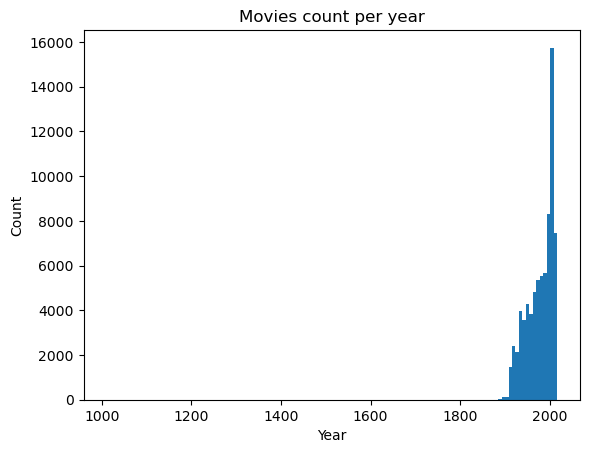

In [5]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df['movie_release_date'].str[:4].astype(float)

nb_bins = movies_df['movie_release_year'].dropna().unique().shape[0]

# Create a histogram with one bin per year
plt.hist(movies_df['movie_release_year'], bins=nb_bins)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

It seems that there are some outliers in years. Let's examine them.

In [6]:
# Show the most recent movies
movies_df.sort_values(by='movie_release_year', ascending=True).head(2)

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.00,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",1010.0
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1888.0


There is only one outlier corresponding to the year 1010, which is highly unlikely. This outlier has the potential to introduce bias into our subsequent analysis, especially when we explore performance trends over time or attempt to standardize our data. Consequently, we have the option to either remove it or attempt to correct it.

According to wikipedia, the _Hunting Season_ movie has been released in 2010 : https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)

Therefore, we will correct this error manually.

In [7]:
# correct the date of the movie
movies_df.loc[62836, 'movie_release_date'] = '2010-12-03'
movies_df.loc[62836, 'movie_release_year'] = 2010

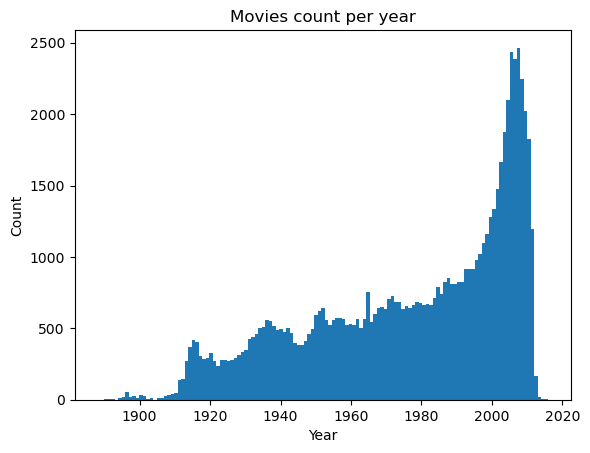

In [8]:
nb_bins = movies_df['movie_release_year'].dropna().unique().shape[0]

# Create a histogram with one bin per year
plt.hist(movies_df['movie_release_year'], bins=nb_bins)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

Now, the chart depicting the distribution of movies over time is more legible. It is evident that our dataset includes a significantly larger number of movies from 1980 to 2010 compared to the earlier period. We will keep this in mind to determine if the imbalanced nature of the dataset over time poses any issues later.

In [9]:
# Calculate the percentage of movies released after 1980
movies_after_1980 = movies_df[movies_df['movie_release_year'] > 1980]
percentage_after_1980 = (len(movies_after_1980) / len(movies_df)) * 100

print(f"Percentage of movies released after 1980: {percentage_after_1980:.2f}%")

Percentage of movies released after 1980: 49.77%


#### Missing data

Given that we assess a movie's performance based on its box office revenue and the number of languages, let's investigate whether we have a sufficient amount of data for these features.

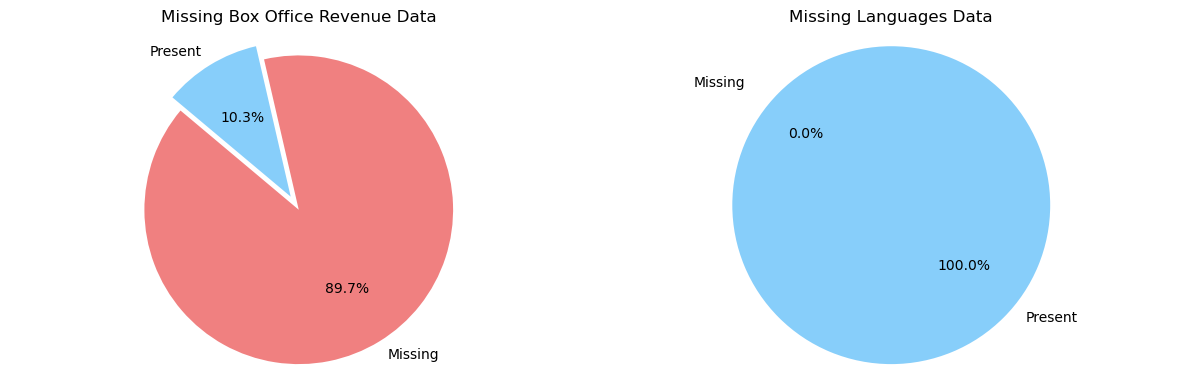

Box Office :
Data missing : 73340
Data present : 8401

Languages :
Data missing : 0
Data present : 81741


In [10]:
# Calculate missing data percentages for 'Box_office_revenue' column
total_movies = len(movies_df)
missing_box_office_count = movies_df['movie_box_office_revenue'].isna().sum()
missing_box_office_percentage = (missing_box_office_count / len(movies_df)) * 100

# Calculate missing data percentages for 'Languages' column
missing_languages_count = movies_df['movie_languages'].isna().sum()
missing_languages_percentage = (missing_languages_count / len(movies_df)) * 100

# Create subplots for both pie charts side by side
plt.figure(figsize=(12, 4))

# First subplot (Box Office Revenue)
plt.subplot(1, 2, 1)
labels_box_office = ['Missing', 'Present']
sizes_box_office = [missing_box_office_percentage, 100 - missing_box_office_percentage]
colors_box_office = ['lightcoral', 'lightskyblue']
explode_box_office = (0.1, 0)  # Explode the "Missing" slice
plt.pie(sizes_box_office, labels=labels_box_office, colors=colors_box_office, autopct='%1.1f%%', explode=explode_box_office, startangle=140)
plt.title('Missing Box Office Revenue Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Second subplot (Languages)
plt.subplot(1, 2, 2)
labels_languages = ['Missing', 'Present']
sizes_languages = [missing_languages_percentage, 100 - missing_languages_percentage]
colors_languages = ['lightcoral', 'lightskyblue']
explode_languages = (0.1, 0)  # Explode the "Missing" slice
plt.pie(sizes_languages, labels=labels_languages, colors=colors_languages, autopct='%1.1f%%', explode=explode_languages, startangle=140)
plt.title('Missing Languages Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()

print(f"Box Office :\nData missing : {missing_box_office_count}\nData present : {total_movies - missing_box_office_count}\n")
print(f"Languages :\nData missing : {missing_languages_count}\nData present : {total_movies - missing_languages_count}")

It appears that 89.9% of the box office revenue data for movies is missing, which accounts for a significant portion of our dataset. Consequently, we will explore whether the movie ratings provide sufficient information for measuring movie performance. The movie rating will be treated in section B.

Concerning the languages, it appears that no information is missing. However, if the language count repartition is almost constant, that would mean that it's not relevant for our analysis. Therefore, let's analyze whether the language count for each movie exhibits heterogeneity.

In [11]:
# Calculate the number of unique languages for each movie
movies_df['movie_languages_count'] = movies_df['movie_languages'].apply(lambda x: len(set(x)))

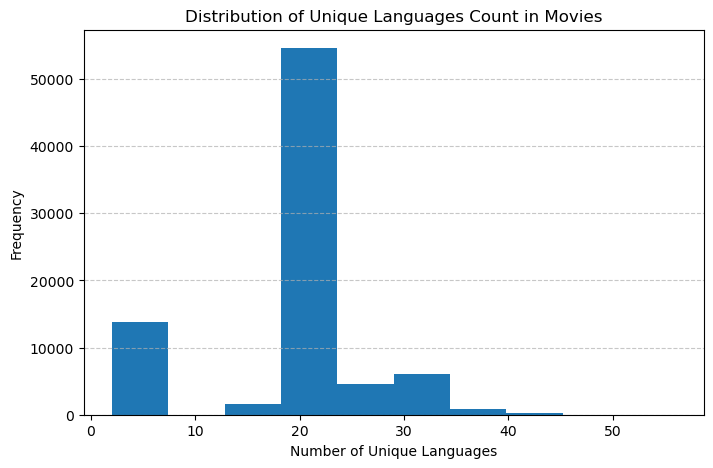

In [12]:
# Create a histogram for the number of unique languages
plt.figure(figsize=(8, 5))
plt.hist(movies_df['movie_languages_count'])
plt.xlabel('Number of Unique Languages')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Languages Count in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Hopefully, there is a variety in the language counts, which would mean that this feature could be relevant for our research.

### Characters dataframe

The `characters` dataframe is from the CMU movies dataset and contains details about movie characters.

In [13]:
characters_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [14]:
total_characters = len(characters_df)
print(f"Number of characters: {total_characters}")
print(f"Number of unique actors: {len(characters_df['character_freebase_id'].unique())}", end="\n\n")

Number of characters: 450669
Number of unique actors: 183436



#### Missing data

Now, let's examine the percentage of missing data for the **Ethnicity**, **Gender**, and **Age** features in our character dataset.

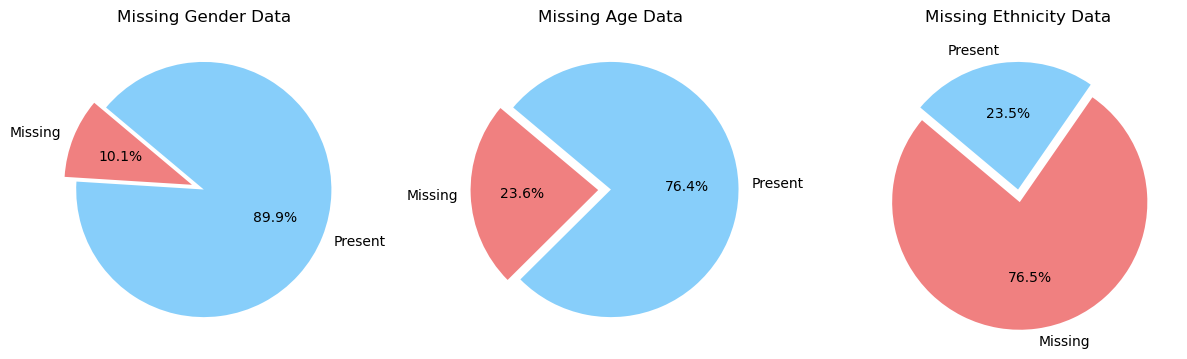

Gender :
Data missing : 45609
Data present : 405060

Age :
Data missing : 106145
Data present : 344524

Ethnicity :
Data missing : 344611
Data present : 106058


In [15]:
# Calculate missing data percentages
total_characters = len(characters_df)
missing_gender_count = characters_df['actor_gender'].isna().sum()
missing_age_count = characters_df['actor_date_of_birth'].isna().sum()
missing_ethnicity_count = characters_df['actor_ethnicity_freebase_id'].isna().sum()
missing_gender_percentage = missing_gender_count / total_characters * 100
missing_age_percentage = missing_age_count / total_characters * 100
missing_ethnicity_percentage = missing_ethnicity_count / total_characters * 100

# Create a pie chart for missing gender data
labels_gender = ['Missing', 'Present']
sizes_gender = [missing_gender_percentage, 100 - missing_gender_percentage]
colors_gender = ['lightcoral', 'lightskyblue']
explode_gender = (0.1, 0)  # Explode the "Missing" slice

plt.figure(figsize=(12, 4))  # Create a larger figure for multiple pie charts

plt.subplot(1, 3, 1)  # Create the first subplot for gender
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, autopct='%1.1f%%', explode=explode_gender, startangle=140)
plt.title('Missing Gender Data')

# Create a pie chart for missing age data
labels_age = ['Missing', 'Present']
sizes_age = [missing_age_percentage, 100 - missing_age_percentage]
colors_age = ['lightcoral', 'lightskyblue']
explode_age = (0.1, 0)  # Explode the "Missing" slice

plt.subplot(1, 3, 2)  # Create the second subplot for age
plt.pie(sizes_age, labels=labels_age, colors=colors_age, autopct='%1.1f%%', explode=explode_age, startangle=140)
plt.title('Missing Age Data')

# Create a pie chart for missing ethnicity data
labels_ethnicity = ['Missing', 'Present']
sizes_ethnicity = [missing_ethnicity_percentage, 100 - missing_ethnicity_percentage]
colors_ethnicity = ['lightcoral', 'lightskyblue']
explode_ethnicity = (0.1, 0)  # Explode the "Missing" slice

plt.subplot(1, 3, 3)  # Create the third subplot for ethnicity
plt.pie(sizes_ethnicity, labels=labels_ethnicity, colors=colors_ethnicity, autopct='%1.1f%%', explode=explode_ethnicity, startangle=140)
plt.title('Missing Ethnicity Data')

plt.tight_layout()  # Ensure proper spacing between subplots

# Display the pie charts
plt.show()

print(f"Gender :\nData missing : {missing_gender_count}\nData present : {total_characters - missing_gender_count}\n")
print(f"Age :\nData missing : {missing_age_count}\nData present : {total_characters - missing_age_count}\n")
print(f"Ethnicity :\nData missing : {missing_ethnicity_count}\nData present : {total_characters - missing_ethnicity_count}")

We notice that a huge percentage of actor's ethnicity is missing. Since our project focuses primarily on actors' ethnicity, this could pose a challenge when we investigate how an actor's ethnicity affects a movie's success.
We have to keep this in mind for our research, so we try to address this data deficiency if needed.

Let's attempt to analyze the distribution of each feature to gain some insights:

**Gender (Categorical)**

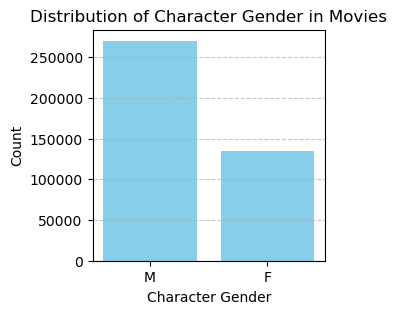

In [16]:
gender_counts = characters_df['actor_gender'].value_counts()

plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values, color='skyblue')
plt.xlabel('Character Gender')
plt.ylabel('Count')
plt.title('Distribution of Character Gender in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

There are approximately twice as many male characters as female characters. However, it's important to clarify that our focus is on the characters themselves rather than the actors portraying them. It would be valuable to conduct a more in-depth analysis to determine whether the distribution of characters aligns with the distribution of actors. This analysis would help us determine if the observed gender disparity is a result of fewer women being involved in the film industry or if roles are simply being unequally assigned.

**Age (Numerical)**

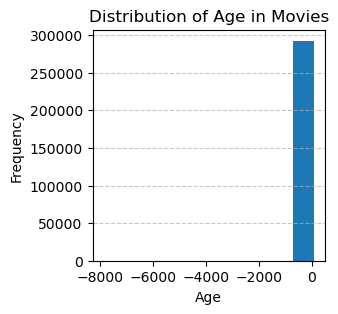

In [17]:
character_ages = characters_df[characters_df['actor_age_at_movie_release'].notna()]['actor_age_at_movie_release']

plt.figure(figsize=(3, 3))
plt.hist(character_ages)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We can observe instances of negative ages that appear to be inconsistent. To better understand their prevalence, we will determine their proportion within the dataset and subsequently remove them as they are considered erroneous data.

In [18]:
# Calculate the percentage of characters with a negative age
total_characters = len(characters_df)
negative_age_characters = len(characters_df[characters_df['actor_age_at_movie_release'] < 0])
percentage_negative_age = (negative_age_characters / total_characters) * 100

print(f"Percentage of characters with a negative age: {percentage_negative_age:.2f}%")

Percentage of characters with a negative age: 0.08%


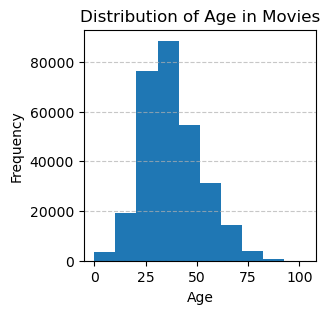

In [19]:
# Drop characters with a negative age in place
characters_df.drop(characters_df[characters_df['actor_age_at_movie_release'] < 0].index, inplace=True)

character_ages2 = characters_df[characters_df['actor_age_at_movie_release'].notna()]['actor_age_at_movie_release']

plt.figure(figsize=(3, 3))
plt.hist(character_ages2)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Looks better !

In [20]:
total_characters = len(characters_df)
print(f"Number of characters after cleaning: {total_characters}")
print(f"Number of unique actors after cleaning: {len(characters_df['character_freebase_id'].unique())}", end="\n\n")

Number of characters after cleaning: 450288
Number of unique actors after cleaning: 183372



**Ethnicity (Categorical)**

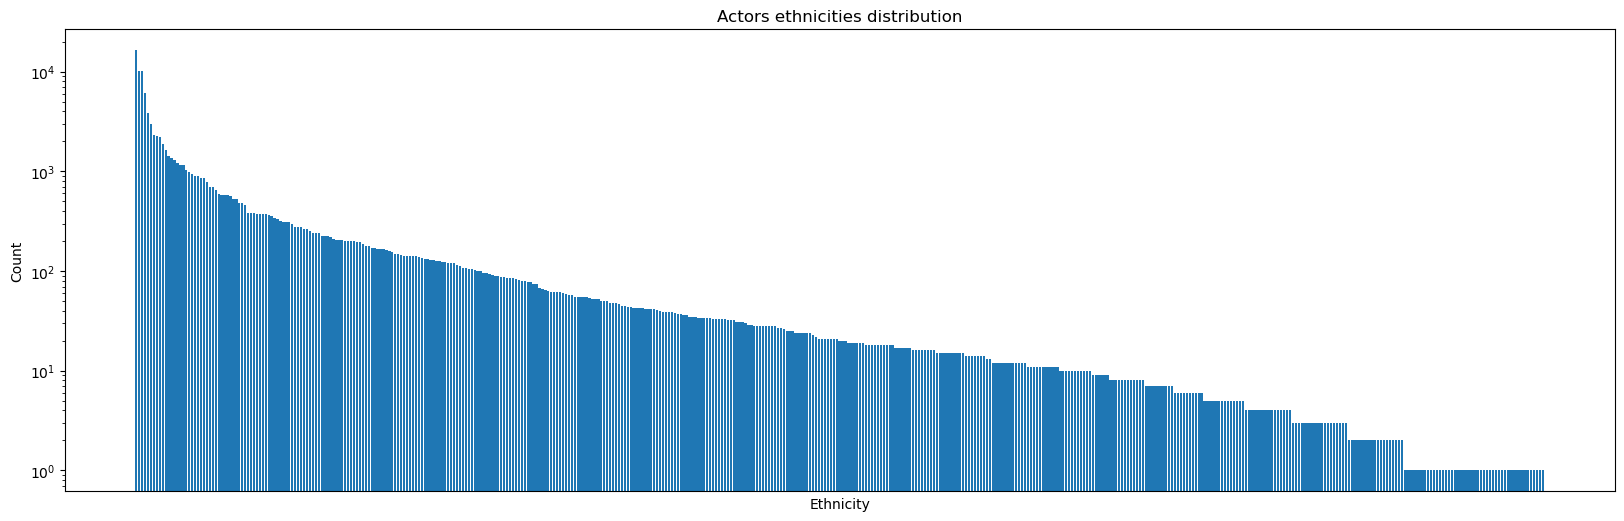

In [21]:
actors_ethnicities = characters_df.groupby(by='actor_ethnicity_freebase_id')["actor_ethnicity_freebase_id"].count().sort_values(ascending=False)

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities.values, label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

The distribution of ethnicities among the characters exhibits significant diversity. While some ethnicities are sparsely represented, others have a notably larger presence in the dataset.

### Plot summaries

The `plot` dataframe comes from the CMU dataset and contains a summary of the plot of a given movie.

In [22]:
plot_summary_df.head()

,movie_wikipedia_id,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [23]:
total_plot = len(plot_summary_df)
print(f"Number of plot summaries loaded: {total_plot}")

# Compute the number of movies without plot summaries
movies_with_summary = movies_df[movies_df['movie_wikipedia_id'].isin(plot_summary_df['movie_wikipedia_id'])]
percentage_with_summary = (len(movies_with_summary) / len(movies_df)) * 100

# Print the percentage of movies without plot summaries
print(f"Percentage of movies with plot summaries: {percentage_with_summary:.2f}%")

Number of plot summaries loaded: 42306
Percentage of movies with plot summaries: 51.64%


### Tvtropes dataframe

The `tvtropes` DataFrame is derived from the CMU dataset and includes records of character types along with the corresponding actors who portray those characters.

In [24]:
tvtropes_df.head()

,character_type,character_name,movie_name,character_actor_freebase_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [25]:
total_tvtropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tvtropes}")

unique_character_types = len(tvtropes_df["character_type"].unique())
print(f"Number of unique character types: {unique_character_types}")

Number of tropes loaded: 501
Number of unique character types: 72


# B) Data collection

Since we aim to get a better understanding of our data, we make use of some online apis to enrich our data. Firstly, as said before, we aim to assess the performance of a movie user ratings. Since those are not available on the provided CMU dataset, we make use of a data fetcher that will try to get as much valuable information as possible. In this notebook, the collected data is loaded only. See [this script file](src/apiQueries.py) to get better insights on the methods used to collect it.

## TMDB 

TMDB is a public movie database that contains information about numerous movies and offers a free access to [their api](https://developer.themoviedb.org/reference/intro/getting-started) that allows to extract information about movies, such as ratings from the platform, budgets if available and more. They recently started to add wikipedia id information inside the movies descriptions but their database seems still very empty in that regard. Another problem that is faced from their api is that it allows to query movie informations for one movie at a time. 

Our proposed solution to this problem was to develop a movie matching algorithm that first queries all movie titles in the database that contains the name of the movie we're looking for. Then, we gather information about all these movies (one query at a time) and we keep the entry that has an exact title match as well as a similar duration (+-3min). The extracted data consists of the average ratings of the movies, the number of votes and, the budgets if available. Since some of these informations aren't public or missing. Lacking entries are filled with zeros.

In [26]:
# Get the generated dataset and remove a duplicate index column
extracted_movie_info = pd.read_csv('generated/TMDB_extra_info.csv').iloc[:,1:]
print("Informations found for {} movies out of {}"
      .format(len(extracted_movie_info),len(movies_df)))
extracted_movie_info.head(4)

Informations found for 40647 movies out of 81741


,title,vote_average,vote_counts,budget
0,Ghosts of Mars,5.125,982,28000000
1,Brun bitter,0.000,0,0
2,White Of The Eye,5.742,64,0
3,A Woman in Flames,5.300,13,0


First analysis on the ratings

In [110]:
# We filter out movies that have a small amout of votes, let's say 30 is representative enough
movie_ratings = extracted_movie_info[extracted_movie_info['vote_counts'] > 30].copy()
movie_ratings = movie_ratings[['title','vote_average','vote_counts']]
print("movies with more than 30 ratings : {}".format(len(movie_ratings)))

movies with more than 30 ratings : 36380


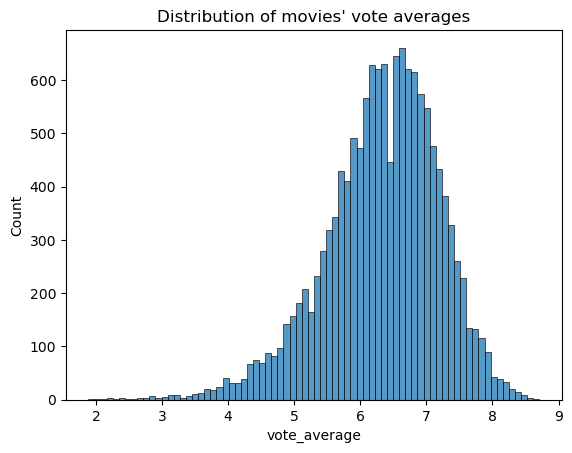

Mean average rating 6.32
Median average rating 6.40


In [28]:
#Show the distribution of votes and some relevant information
sns.histplot(data=movie_ratings,x='vote_average')
plt.title("Distribution of movies' vote averages")
plt.show()

print("Mean average rating {:.2f}\nMedian average rating {:.2f}"
      .format(movie_ratings['vote_average'].mean(),movie_ratings['vote_average'].median()))

The distribution seems to follow a gaussian distribution. Let's investigate that a bit more.

In [29]:
normaltest(movie_ratings['vote_average'])

NormaltestResult(statistic=1057.8150882573825, pvalue=1.9877975358998406e-230)

The p-value is way under 0.05, which means that we reject the null hypothesis that the samples were drawn from a normal distribution.

Now let's have a look at the few budgets extracted from TMDB

In [30]:
# Extract movies that contain budgets above a million to generate a dataframe that allows
# comparisons of movies developed under what is considered high budgets
movies_budgets = extracted_movie_info[extracted_movie_info["budget"] > 1e6].copy()
movies_budgets = movies_budgets[['title','budget']]
min_budget =movies_budgets['budget'].min()
max_budget = movies_budgets['budget'].max()
print('number of movies that have a budget higher than 1 Million : {}'
      .format(len(movies_budgets)))

number of movies that have a budget higher than 1 Million : 5606


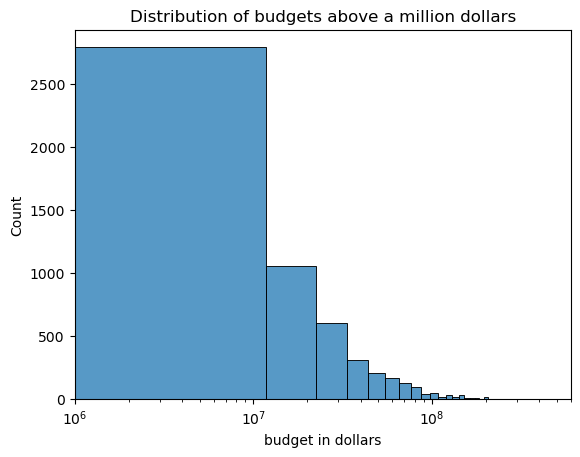

The median movie has a budget of 12000000.0
The cheapest movie costed 1001000
The most expensive movie costed 540000000


In [31]:
## Get the informations of the highest and smallest budgets for movies above a million
## and plot the overall distribution
sns.histplot(data=movies_budgets,x='budget',bins=50)
plt.title('Distribution of budgets above a million dollars')
plt.xlim([1e6,6e8])
plt.xlabel('budget in dollars')
plt.xscale('log')
plt.show()
print('The median movie has a budget of {}'.format(movies_budgets['budget'].median()))
print('The cheapest movie costed {}\nThe most expensive movie costed {}'
      .format(min_budget,max_budget))

Text(0.5, 1.0, 'CCDF of budgets above a million dollars')

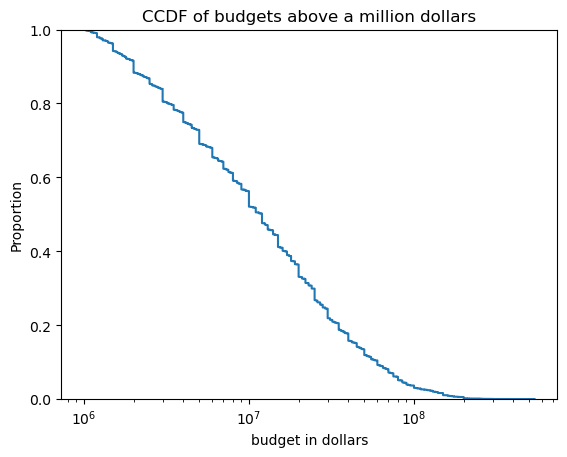

In [32]:
## Plot a ccdf to get a better idea of the budget distribution above a million dollars
sns.ecdfplot(data=movies_budgets,x='budget',complementary=True,log_scale=True)
plt.xlabel('budget in dollars')
plt.title('CCDF of budgets above a million dollars')

We remark that the distribution of budgets above 1 million doesn't necessarily follow a power law but it makes it very clear that a vast majority of movies are developed with a budgets under 10 millions. 

This data will allow us to compare movies that are still considered high budgets and help us making coherent grouping when trying to perform causal analysis on the impact diversity has.
This data may be important because comparing only box office revenues could bring a consequent bias. However, we have to keep in mind that this subsample represent a very small set of the population.

## Wikipedia database

The dataset is composed of numerous entries in FreeBaseID format. Those are not very verbose and don't allow to understand exactly what is represented by these features. We therefore make use of the wikipedia database to extract the related labels of those ids.

In [33]:
FB_ids = characters_df['actor_ethnicity_freebase_id'].dropna().unique()

In [89]:
label_ethnicity_df = pd.read_csv('./generated/ethnicities_labels.csv',names=['actor_ethnicity_freebase_id','actor_ethnicity'])
label_ethnicity_df.head(4)

,actor_ethnicity_freebase_id,actor_ethnicity
0,/m/0790v,Slavs
1,/m/03kbr,Hindu
2,/m/01km_m,Slovenes
3,/m/013y54,Han Chinese people


In [91]:
print(np.unique(label_ethnicity_df["actor_ethnicity"]))

['Aboriginal Australians' 'Acadians' 'Aceh' 'Afghans in India'
 'African Americans' 'African people' 'Afrikaners'
 'Afro Trinidadians and Tobagonians' 'Afro-Asians' 'Afro-Cuban'
 'Afro-Guyanese' 'Agrawal' 'Akan people' 'Albanian American' 'Albanians'
 'American Jews' 'Americans' 'Anglo-Celtic Australians'
 'Anglo-Indian people' 'Anglo-Irish people' 'Apache' 'Arab Americans'
 'Arab Mexican' 'Arabs' 'Arabs in Bulgaria' 'Argentines'
 'Armenian American' 'Armenians' 'Armenians in Italy'
 'Armenians of Russia' 'Aromanians' 'Ashkenazi Jews' 'Asian Americans'
 'Asian people' 'Assyrian people' 'Australian American' 'Australians'
 'Austrian Americans' 'Austrians' 'Austrians in the United Kingdom'
 'Aymara' 'Azerbaijanis' 'Bahamian Americans' 'Baltic Russians'
 'Bangladeshi American' 'Barbadian American' 'Basque people' 'Belarusians'
 'Belgians' 'Bengali Brahmins' 'Bengali Hindus' 'Bengali people' 'Berber'
 'Bhutia' 'Bihari people' 'Black British' 'Black Canadians'
 'Black Hispanic and Latino Am

A very interesting aspect we note here is that ethnicities here are, as expected, precisely defined as the entity of actors instead of their country of origin, which is a richer concept and good news for the analysis.

# C) Data generation from given datasets

This section is designated for creating the basic Data Frames that will be used in our research.

### 1) Movies, Characters, Ethnicities

Previously we saw that a lot of ethnicities were missing, which would made us lose a lot of information during the merging. Therefore we will generate 2 dataframes : 

- `movie_characters_df` : Will be useful when analysing the age and gender diversity
- `movie_characters_ethnicity_df` : Will be useful when analysing the ethnicity disparity.
    
Only the second one will suffer from lack of data.

In [35]:
# Merging the 'movies_df' and 'characters_df' DataFrames using an inner join on the 'Wikipedia_ID' and 'Wikipedia_movie_ID' columns

movie_characters_df = pd.merge(movies_df, characters_df, on=['movie_wikipedia_id', 'movie_freebase_id', 'movie_release_date'], how='inner')
movie_characters_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,...,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [36]:
# Merging with the ethnicity label
movie_characters_ethnicity_df = pd.merge(movie_characters_df, label_ethnicity_df, on="actor_ethnicity_freebase_id", how='inner')
movie_characters_ethnicity_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,...,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id,actor_ethnicity
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans
2,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,...,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,African Americans
3,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001.0,...,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,/m/0jtx5t,/m/03jnxj_,/m/0blbxk,African Americans
4,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001.0,...,1978-12-30,M,1.797,/m/0x67,Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,African Americans


In [37]:
# Display the shape of the 'movie_characters_df' DataFrame
print("Shape of 'movie_characters_df':", movie_characters_df.shape)
print("Shape of 'movie_characters_ethnicity_df':", movie_characters_ethnicity_df.shape)

Shape of 'movie_characters_df': (450273, 21)
Shape of 'movie_characters_ethnicity_df': (102934, 22)


There are approximately four times as many samples in the `movie_characters_df` compared to the `movie_characters_ethnicity_df`. Therefore, we can confidently conclude that it is necessary to store both dataframes.

Finally, we postpone the removal of `NaN` values until later in the research. This way, we can eliminate the `NaN` values specifically from the feature that is relevant to each step, ensuring that we do not discard valuable data unnecessarily.

Now we can store our datasets in csv files, but we should keep only relevant columns !

In [38]:
# List of columns to keep, in specific order for better readability.
columns_to_keep_no_ethnicity = [
    'movie_wikipedia_id',
    'movie_freebase_id',
    'movie_name',
    'movie_release_year',
    'movie_languages_count',
    'movie_box_office_revenue',
    'character_freebase_id',
    'actor_freebase_id',
    'character_actor_freebase_map_id',
    'character_name',
    'actor_name',
    'actor_gender',
    'actor_age_at_movie_release',
]

columns_to_keep_ethnicity = columns_to_keep_no_ethnicity + ['actor_ethnicity']

print(f"Number of columns of movie_characters_df before filtering: {movie_characters_df.shape[1]}")
movie_characters_df = movie_characters_df[columns_to_keep_no_ethnicity]
print(f"Number of columns of movie_characters_df after filtering: {movie_characters_df.shape[1]}")

print()

print(f"Number of columns of movie_characters_ethnicity_df before filtering: {movie_characters_ethnicity_df.shape[1]}")
movie_characters_ethnicity_df = movie_characters_ethnicity_df[columns_to_keep_ethnicity]
print(f"Number of columns of movie_characters_ethnicity_df after filtering: {movie_characters_ethnicity_df.shape[1]}")

Number of columns of movie_characters_df before filtering: 21
Number of columns of movie_characters_df after filtering: 13

Number of columns of movie_characters_ethnicity_df before filtering: 22
Number of columns of movie_characters_ethnicity_df after filtering: 14


In [39]:
# Save the generated data frames in cvs file
movie_characters_df.to_csv('generated/movie_characters.csv', index=False)
movie_characters_ethnicity_df.to_csv('generated/movie_characters_ethnicity.csv', index=False)

### 2) Movies, Characters, Plots, TVtropes

Now we will generate a dataframe with movies, characters and plots. This one will be used in our analysis of stereotypes associated with roles and the significance of these roles.

In [40]:
# Merging the 'movie_characters_df' and 'plot_summary_df' DataFrames using an inner join on the 'Wikipedia_ID' and 'Wikipedia_movie_ID' columns

movie_characters_plot_df = pd.merge(plot_summary_df, movie_characters_df, how='inner')
movie_characters_plot_tvtropes_df = pd.merge(movie_characters_plot_df, tvtropes_df, how='inner')

movie_characters_plot_tvtropes_df.head()

,movie_wikipedia_id,movie_plot,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,character_freebase_id,actor_freebase_id,character_actor_freebase_map_id,character_name,actor_name,actor_gender,actor_age_at_movie_release,character_type
0,6002183,"In the Jungle of Nool, a tiny dust speck is pu...",/m/0fk25m,Horton Hears a Who!,2008.0,22,297138014.0,/m/04xnbs,/m/0lx2l,/m/05tgl99,Horton the Elephant,Jim Carrey,M,46.0,warrior_poet
1,45772,"On November 25, 1975, Rocky Balboa is introd...",/m/0cf08,Rocky,1976.0,22,225000000.0,/m/0cg655,/m/0234pg,/m/0k2n0d,Apollo Creed,Carl Weathers,M,28.0,arrogant_kungfu_guy
2,1238102,"The film opens in the Bronx, where The Lieuten...",/m/04l40p,Bad Lieutenant,1992.0,27,2019469.0,/m/0bdwp2l,/m/0klh7,/m/0jtz28,The Lieutenant,Harvey Keitel,M,53.0,dirty_cop
3,133688,The Piano tells the story of a mute Scotswoman...,/m/0_b9f,The Piano,1993.0,30,40157856.0,/m/0h2qv1_,/m/01ckhj,/m/0k63tb,Alisdair Stewart,Sam Neill,M,45.0,crazy_jealous_guy
4,77223,Tony Wendice is an ex-professional tennis play...,/m/0k7tq,Dial M for Murder,1954.0,22,6000000.0,/m/0528dy7,/m/0f0p0,/m/0jx7qr,Tony Wendice,Ray Milland,M,47.0,crazy_jealous_guy


In [41]:
# Display the shape of the generated dataframes
print("Shape of 'movie_characters_plot_df':", movie_characters_plot_df.shape)
print("Shape of 'movie_characters_plot_tvtropes_df':", movie_characters_plot_tvtropes_df.shape)

Shape of 'movie_characters_plot_df': (308257, 14)
Shape of 'movie_characters_plot_tvtropes_df': (501, 15)


Again there is a huge lose of data for the `movie_characters_plot_tvtropes_df`. Therefore we will store both dataframes.
Moreover, as these dataframe were generated from the `movie_characters`, we notice that we don't need to filter their columns again.

In [42]:
movie_characters_plot_df.to_csv('generated/movie_characters_plot.csv', index=False)
movie_characters_plot_tvtropes_df.to_csv('generated/movie_characters_plot_tvtropes.csv', index=False)

# D) Test our generated datasets

### 1) Movies, Characters, Ethnicities

In [43]:
# Load our generated datasets
movie_characters_test_df = pd.read_csv('generated/movie_characters.csv')
movie_characters_ethnicity_test_df = pd.read_csv('generated/movie_characters_ethnicity.csv')

Let's get some insights from the ethnicity repartition.

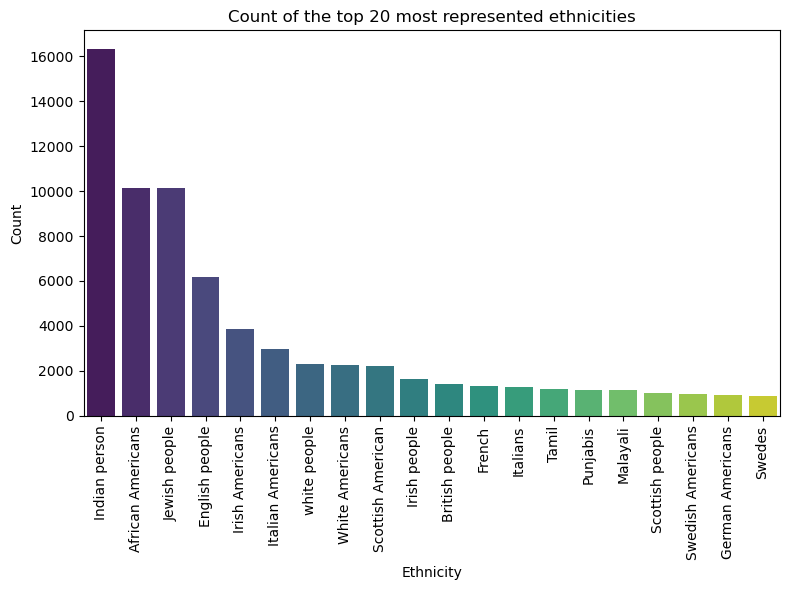

In [44]:
# Compute and sort the ethnicity distribution
ethnicity_distribution = movie_characters_ethnicity_test_df['actor_ethnicity'].value_counts()
sorted_ethnicity_distribution = ethnicity_distribution.sort_values(ascending=False)

# Keep only the top 20 values
top_20_ethnicities = sorted_ethnicity_distribution.head(20)

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=top_20_ethnicities.index, y=top_20_ethnicities.values, palette='viridis')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Count of the top 20 most represented ethnicities')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the bar chart
plt.tight_layout()
plt.show()

The distribution appears to be heterogeneous, offering us the chance to make assumptions about the more prevalent and less common ethnicities. It's important to note that this first chart reflects the ethnicities for each character appearance. Therefore, it's possible for a single actor to contribute to the chart multiple times.

Let's get some insights from the gender repartition. This time, we will use the `movie_characters_test_df` so we use the maximum data.

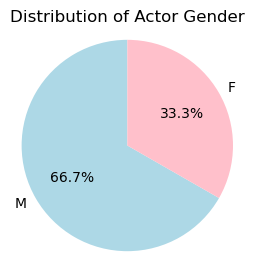

In [45]:
# Calculate the gender distribution
gender_distribution = movie_characters_test_df['actor_gender'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Distribution of Actor Gender')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Show the pie chart
plt.show()

Finally, let's get some insights from the age repartition, again on the `movie_characters_test_df`.

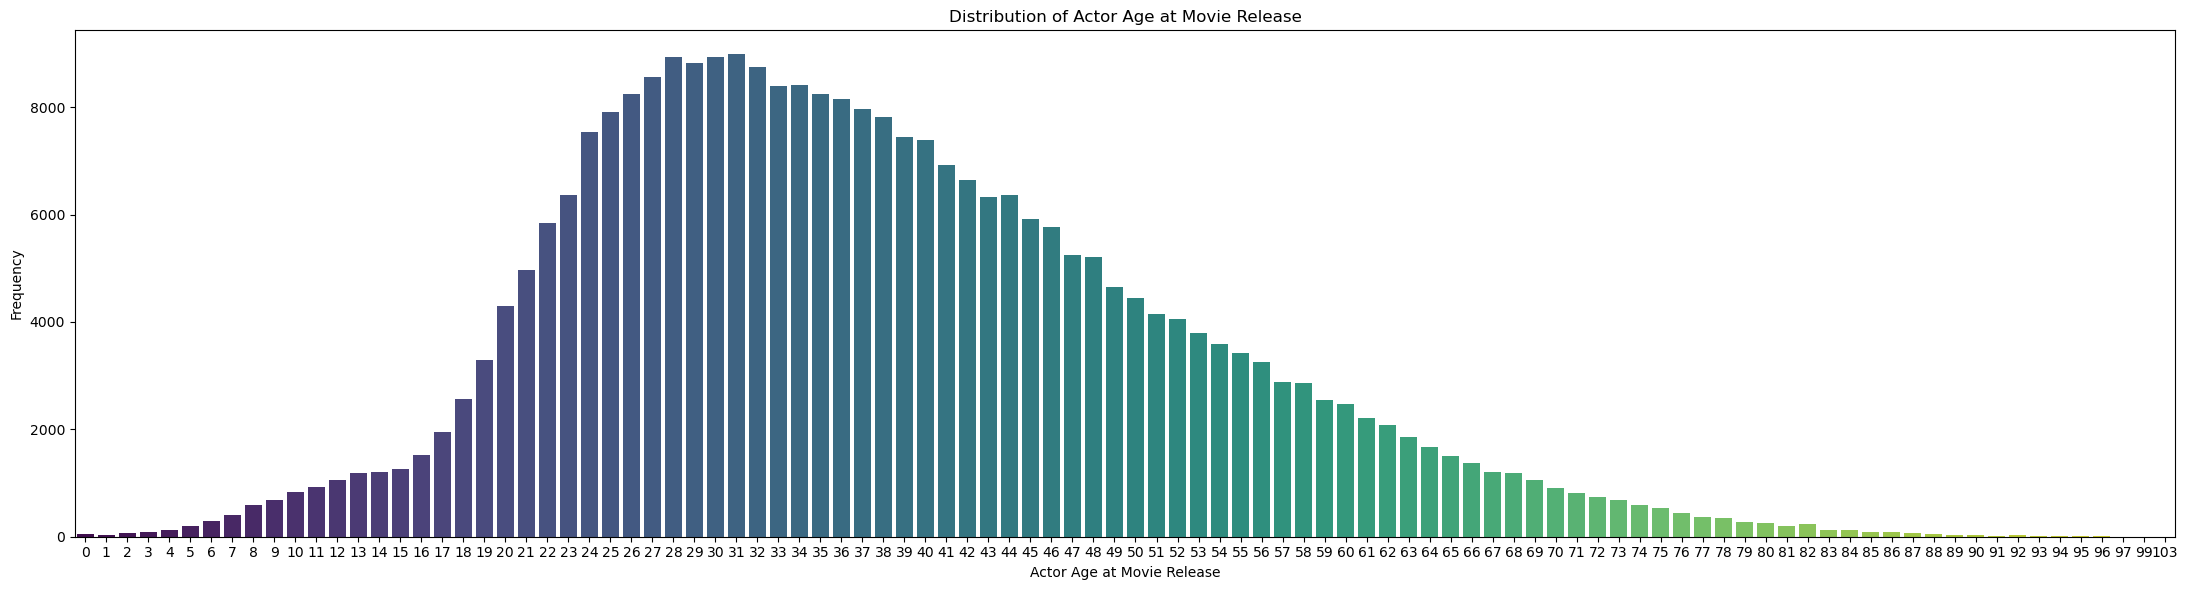

In [46]:
# Calculate the age distribution
age_distribution = movie_characters_test_df['actor_age_at_movie_release'].value_counts()

# Create a histogram
plt.figure(figsize=(22, 6))
sns.barplot(x=age_distribution.index.astype(int), y=age_distribution.values, palette='viridis')
plt.xlabel('Actor Age at Movie Release')
plt.ylabel('Frequency')
plt.title('Distribution of Actor Age at Movie Release')

# Show the histogram
plt.tight_layout()
plt.show()

### 2) Movies, Characters, Plots, TVtropes

In [47]:
# Load our generated datasets
movie_characters_plot_df = pd.read_csv('generated/movie_characters_plot.csv')
movie_characters_plot_tvtropes_df = pd.read_csv('generated/movie_characters_plot_tvtropes.csv')

Let's try an example on the movie _"Pirates of the Caribbean: Dead Man's Chest"_

In [48]:
# The names of the characters in the movie_characters_plot_tvtropes_df dataframes are :
unique_characters = movie_characters_plot_df[movie_characters_plot_df['movie_name'] == "Pirates of the Caribbean: Dead Man's Chest"]["character_name"].unique()
print("The names of the characters in the movie 'Pirates of the Caribbean: Dead Man's Chest' are:")
print(unique_characters)

The names of the characters in the movie 'Pirates of the Caribbean: Dead Man's Chest' are:
['Cutler Beckett' 'Captain Jack Sparrow' 'Will Turner' 'Elizabeth Swann'
 'Norrington' 'Davy Jones' 'Governor Weatherby Swann' 'Pintel' 'Ragetti'
 'Joshamee Gibbs' 'Cotton' 'Bootstrap Bill Turner' 'Tia Dalma' 'Marty'
 'Mercer' 'Captain Bellamy' 'Scarlett' 'Leech' 'Very Old Man'
 'Hector Barbossa']


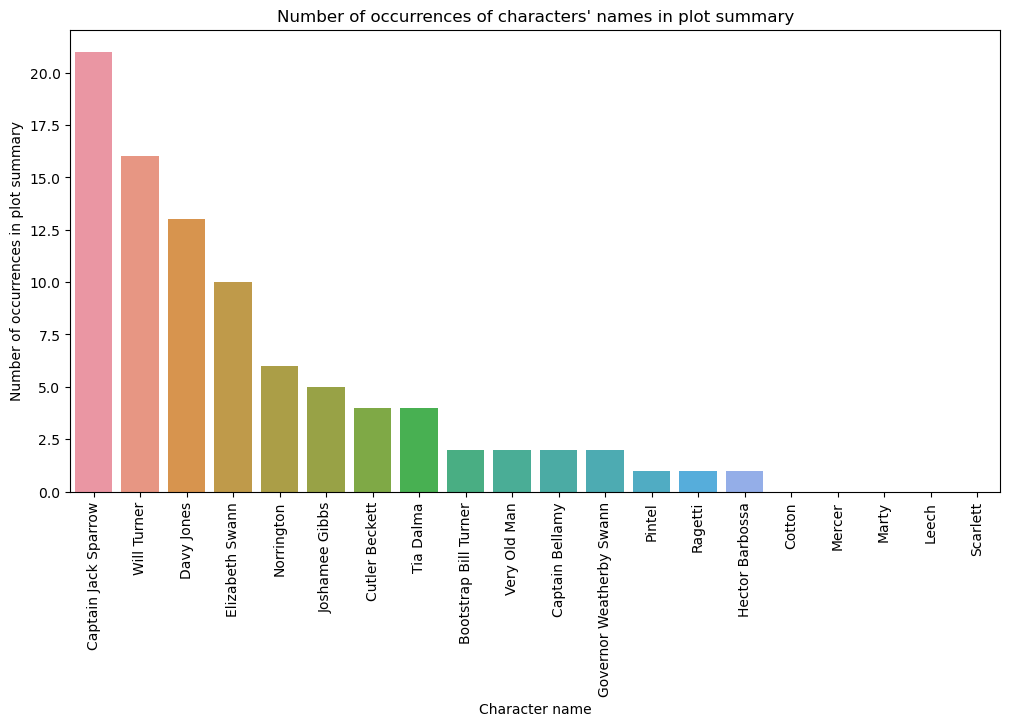

In [49]:
# Example our generated dataframe with Pirate of the Caribbean
pirate_df = movie_characters_plot_df[movie_characters_plot_df['movie_name'] == "Pirates of the Caribbean: Dead Man's Chest"].copy()

# Compute the frequency of apparition of each character in Pirate of the Caribbean in the plot summary
pirate_df['frequency_apparition'] = pirate_df.apply(lambda row: compute_apparition_frequency(row['character_name'], row['movie_plot']), axis=1)

unique_pirate_df = pirate_df.drop_duplicates(subset="actor_name", keep="first")
unique_pirate_df = unique_pirate_df.sort_values(by="frequency_apparition", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
plot = sns.barplot(x=unique_pirate_df['character_name'], y=unique_pirate_df['frequency_apparition'])

# Rotate the x-axis labels by 90 degrees
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.xlabel('Character name')
plt.ylabel('Number of occurrences in plot summary')
plt.title("Number of occurrences of characters' names in plot summary")

plt.show()

This chart relies on the performance of the function responsible for calculating the occurrences `compute_apparition_frequency`. While there is room for potential improvements in this function in the future, it currently appears to be functioning quite effectively.

## How is diversity exploited in movies

### How can roles be categorized based on the ethnicity, gender and age of the actors ?

méthode: on veut comprendre si on a des rôles typiques associés à des ethnicités, genres, ou tranches d'âges donnés. Première idée, faire une régression linéaire pour voir si on arrive à faire un prédicteur

In [50]:
import statsmodels.formula.api as smf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [51]:
movie_char_eth = pd.read_csv('./generated/movie_characters_ethnicity.csv')
movie_char_tvt = pd.read_csv('./generated/movie_characters_plot_tvtropes.csv')

In [52]:
mce = movie_char_eth[['character_actor_freebase_map_id', 'actor_gender','actor_age_at_movie_release','actor_ethnicity']].copy()
tvt = tvtropes_df[['character_actor_freebase_map_id','character_type']].copy()

In [53]:
mce

,character_actor_freebase_map_id,actor_gender,actor_age_at_movie_release,actor_ethnicity
0,/m/0jys3g,M,32.0,African Americans
1,/m/02vdcfp,F,52.0,African Americans
2,/m/0lr37dy,M,62.0,African Americans
3,/m/0jtx5t,F,30.0,African Americans
4,/m/0jtx5h,M,22.0,African Americans
...,...,...,...,...
102929,/m/0gfjqwt,M,NaN,Sierra Leone Creole people
102930,/m/0gbmz7d,F,22.0,Goans
102931,/m/0jzmncg,M,22.0,Hutsuls
102932,/m/0n22hrq,M,NaN,Bohemian


In [54]:
char_diversity_attributes  = pd.merge(left = mce,
         right=tvt,
         left_on="character_actor_freebase_map_id",
         right_on='character_actor_freebase_map_id',
         how='inner')[['actor_gender','actor_ethnicity','actor_age_at_movie_release','character_type']].copy()

dataset = char_diversity_attributes.copy().dropna()

In [55]:
dataset

,actor_gender,actor_ethnicity,actor_age_at_movie_release,character_type
0,M,African Americans,40.0,father_to_his_men
1,M,African Americans,45.0,henpecked_husband
2,M,African Americans,35.0,egomaniac_hunter
3,M,African Americans,55.0,crazy_survivalist
4,M,African Americans,59.0,dirty_cop
...,...,...,...,...
314,M,Irish Canadians,36.0,fastest_gun_in_the_west
315,M,Akan people,37.0,cultured_badass
316,M,Akan people,37.0,hitman_with_a_heart
317,M,Irish Australian,26.0,casanova


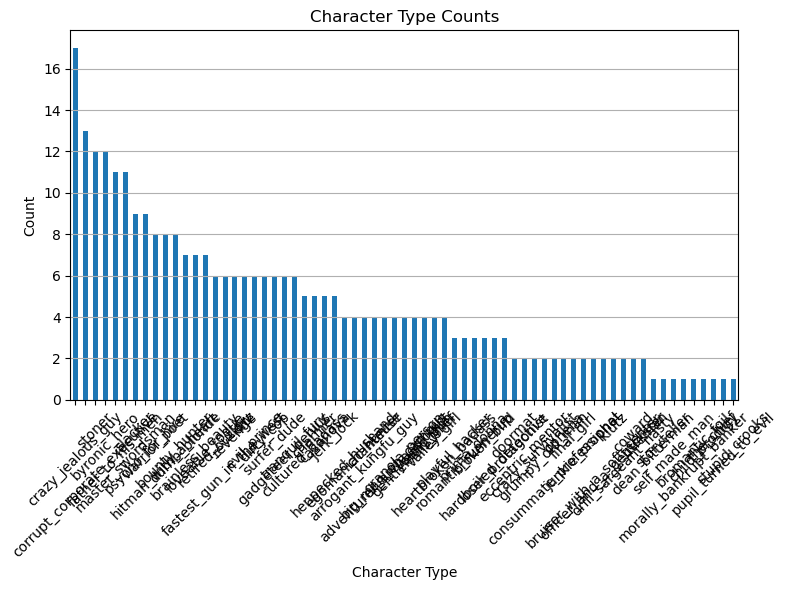

In [56]:
import matplotlib.pyplot as plt

# Plotting the histogram for character_type counts
plt.figure(figsize=(8, 6))
character_types_less_than_2 =  dataset['character_type'].value_counts().plot(kind='bar')
plt.title('Character Type Counts')
plt.xlabel('Character Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [57]:
character_type_counts = dataset['character_type'].value_counts()

# Finding character types that appear less than 2 times
character_types_less_than_2 = character_type_counts[character_type_counts > 0].index

# Filtering the dataset
dataset = dataset[dataset['character_type'].isin(character_types_less_than_2)]
len(dataset)

312

In [58]:
# Clusters
clusters = {
    "Action-Oriented and Adventurous": ['adventurer_archaeologist', 'bounty_hunter', 'bruiser_with_a_soft_center', 
                                        'byronic_hero', 'cultured_badass', 'fastest_gun_in_the_west', 
                                        'father_to_his_men', 'gentleman_thief', 'heartbroken_badass', 
                                        'hitman_with_a_heart', 'master_swordsman', 'officer_and_a_gentleman', 
                                        'retired_outlaw', 'warrior_poet', 'crazy_survivalist', 'the_chief', 'young_gun'],
    "Intelligent and Skillful": ['big_man_on_campus', 'child_prodigy', 'consummate_professional', 
                                 'gadgeteer_genius', 'playful_hacker', 'storyteller', 'self_made_man'],
    "Criminal and Antagonistic": ['arrogant_kungfu_guy', 'corrupt_corporate_executive', 'dirty_cop', 
                                  'egomaniac_hunter', 'evil_prince', 'morally_bankrupt_banker', 
                                  'psycho_for_hire', 'pupil_turned_to_evil', 'stupid_crooks'],
    "Comedic or Light-Hearted": ['brainless_beauty', 'bromantic_foil', 'casanova', 'charmer', 'ditz', 
                                 'granola_person', 'henpecked_husband', 'jerk_jock', 'klutz', 'loser_protagonist', 
                                 'loveable_rogue', 'slacker', 'stoner', 'surfer_dude', 'valley_girl', 'chanteuse', 'prima_donna'],
    "Tragic or Suffering Characters": ['broken_bird', 'coward', 'crazy_jealous_guy', 'dean_bitterman', 
                                       'doormat', 'drill_sargeant_nasty', 'dumb_blonde', 'eccentric_mentor', 
                                       'final_girl', 'grumpy_old_man', 'hardboiled_detective', 'junkie_prophet', 
                                       'ophelia', 'romantic_runnerup', 'tranquil_fury', 'trickster', 'revenge']
}

# Function to map character types to their clusters
def map_to_cluster(character_type):
    for cluster_name, types in clusters.items():
        if character_type in types:
            return cluster_name
    return "Unknown"

dataset['cluster'] = dataset['character_type'].apply(map_to_cluster)

np.unique(dataset[dataset["cluster"] == "Unknown"]["character_type"])

array([], dtype=object)

In [59]:
# Standardize the age column
dataset['actor_age_at_movie_release'] = (dataset['actor_age_at_movie_release']-dataset['actor_age_at_movie_release'].mean())/dataset['actor_age_at_movie_release'].std()

In [60]:
dataset

,actor_gender,actor_ethnicity,actor_age_at_movie_release,character_type,cluster
0,M,African Americans,0.267719,father_to_his_men,Action-Oriented and Adventurous
1,M,African Americans,0.690005,henpecked_husband,Comedic or Light-Hearted
2,M,African Americans,-0.154568,egomaniac_hunter,Criminal and Antagonistic
3,M,African Americans,1.534578,crazy_survivalist,Action-Oriented and Adventurous
4,M,African Americans,1.872407,dirty_cop,Criminal and Antagonistic
...,...,...,...,...,...
314,M,Irish Canadians,-0.070110,fastest_gun_in_the_west,Action-Oriented and Adventurous
315,M,Akan people,0.014347,cultured_badass,Action-Oriented and Adventurous
316,M,Akan people,0.014347,hitman_with_a_heart,Action-Oriented and Adventurous
317,M,Irish Australian,-0.914683,casanova,Comedic or Light-Hearted


In [61]:
feature_cols = ['actor_gender', "actor_age_at_movie_release", "actor_ethnicity"]
label_cols = ['character_type']
X = pd.get_dummies(dataset[feature_cols],drop_first=True)
y = dataset[label_cols]

In [62]:
from sklearn.model_selection import cross_val_score

# Creating a logistic regression model with 'lbfgs' solver
log_reg_cv = LogisticRegression(solver='lbfgs')

logistic.fit(X=X,y=np.array(y).ravel())

NameError: name 'logistic' is not defined

In [ ]:
y_pred = logistic.predict(X)

In [ ]:
accuracy_score(y_true=y,y_pred=y_pred)

In [63]:
from scipy.stats import chi2_contingency

# Creating a contingency table
contingency_table = pd.crosstab(dataset['character_type'], dataset['actor_gender'])

# Performing the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Displaying the results
print("Chi-Square value:", chi2)
print("P-value:", p)

# Interpretation of the result
if p < 0.05:
    print("There is a significant relationship between character type and actor gender.")
else:
    print("There is no significant relationship between character type and actor gender.")


Chi-Square value: 252.71655328798187
P-value: 1.2015777107209548e-23
There is a significant relationship between character type and actor gender.


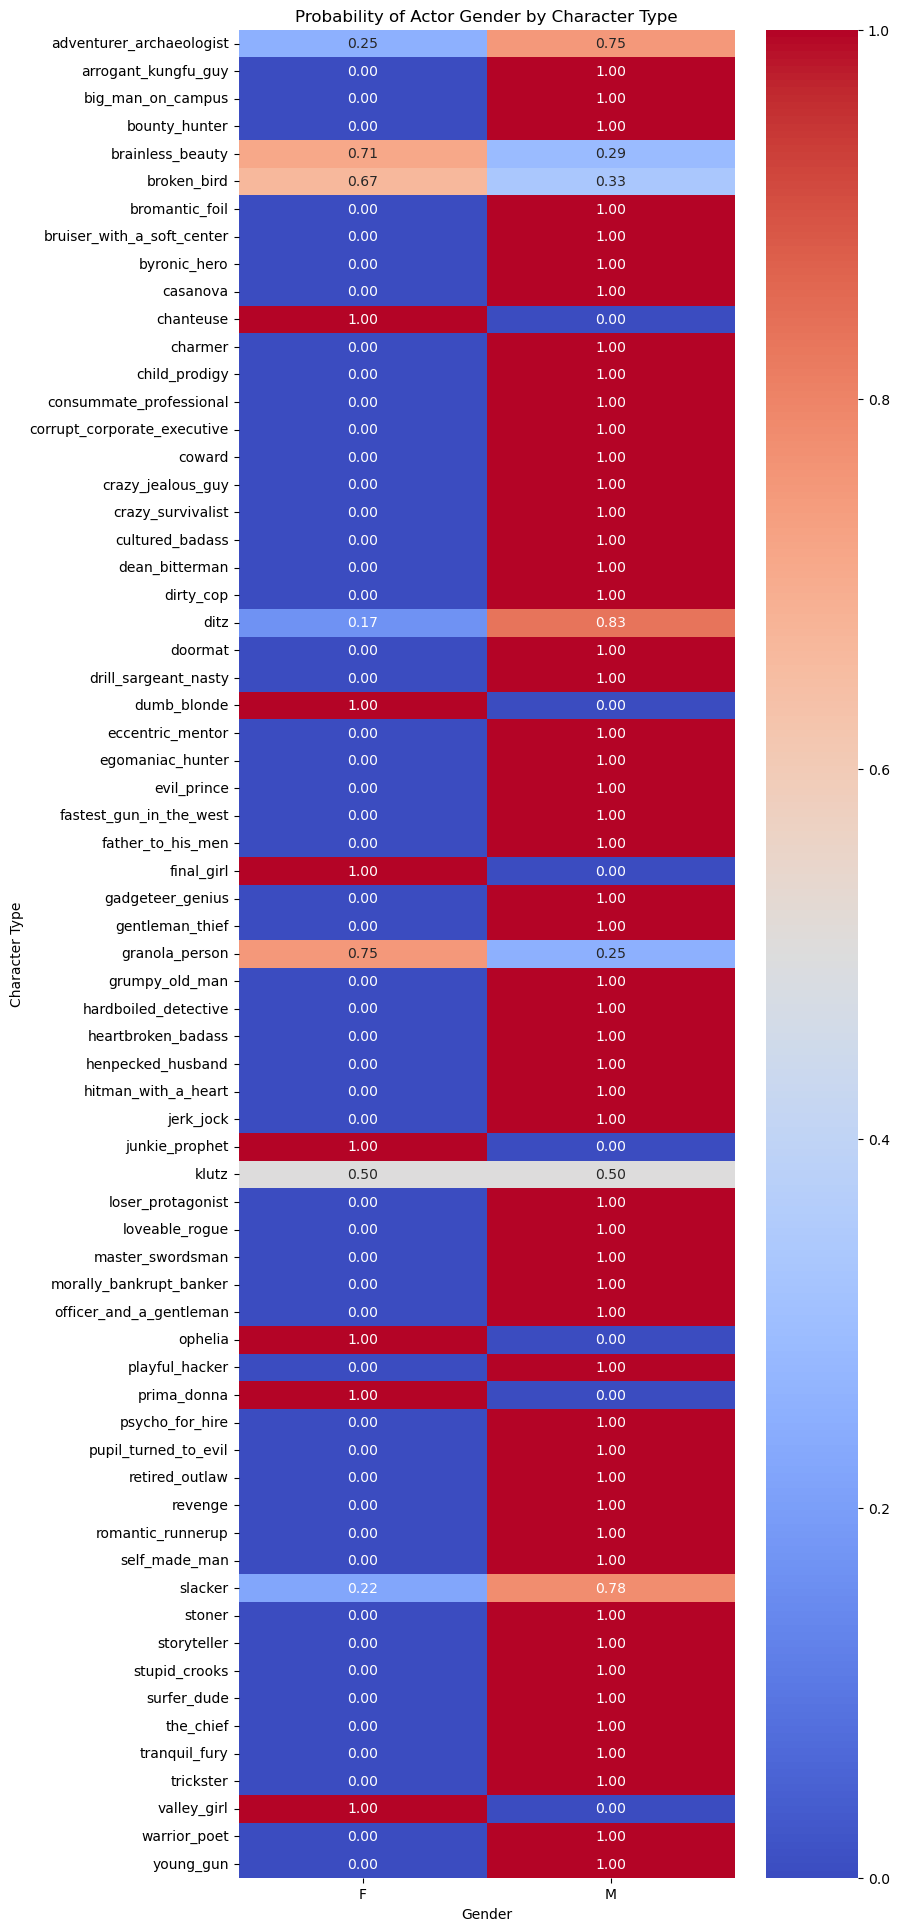

In [64]:
# Group by 'character_type' and count genders
gender_counts = dataset.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)

# Calculate probabilities
probabilities = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# Creating the heatmap
plt.figure(figsize=(8, 24))
sns.heatmap(probabilities, annot=True, cmap='coolwarm', fmt=".2f")

# Adding titles and labels
plt.title('Probability of Actor Gender by Character Type')
plt.ylabel('Character Type')
plt.xlabel('Gender')

# Show the plot
plt.show()

In [65]:
# Creating a contingency table
contingency_table = pd.crosstab(dataset['character_type'], dataset['actor_ethnicity'])

# Performing the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Displaying the results
print("Chi-Square value:", chi2)
print("P-value:", p)

# Interpretation of the result
if p < 0.05:
    print("There is a significant relationship between character type and actor ethnicity.")
else:
    print("There is NO significant relationship between character type and actor ethnicity.")


Chi-Square value: 4442.0470181029605
P-value: 0.05158773836144359
There is NO significant relationship between character type and actor ethnicity.


In [66]:
from scipy.stats import f_oneway

# Grouping the dataset by 'character_type'
grouped = dataset.groupby('character_type')['actor_age_at_movie_release'].apply(list)

# Performing One-Way ANOVA
anova_result = f_oneway(*grouped)

# Displaying the results
print("ANOVA F-value:", anova_result.statistic)
print("P-value:", anova_result.pvalue)

# Interpretation of the result
if anova_result.pvalue < 0.05:
    print("There is a significant difference in ages across different character types.")
else:
    print("There is NO significant difference in ages across different character types.")

ANOVA F-value: 4.10791488601123
P-value: 4.504956378622861e-16
There is a significant difference in ages across different character types.


## What is the centrality of characters portrayed by diverse actors in the plots of the movies ?

Là il va peut-être falloir préciser un poil plus ce qu'on veut rechercher mais une bonne première approche ce serait sûrement si on a des bons résultats en partie 1 de déterminer si ces rôles associés à certaines catégories sont présents dans les plot summaries ou pas

## What type of stereotypical roles are frequently assigned to these actors and how prevalent are they in films ?

C'est un peu similaire à la première question, à voir exactement comment on développe l'analyse

# Correlation diversity rating

In [94]:
mc = movie_characters_df[["movie_name", 'actor_gender','actor_age_at_movie_release']].copy().copy()
mce = movie_char_eth[["movie_name", 'actor_gender','actor_age_at_movie_release','actor_ethnicity']].copy()

mc

,movie_name,actor_gender,actor_age_at_movie_release
0,Ghosts of Mars,F,42.0
1,Ghosts of Mars,F,27.0
2,Ghosts of Mars,M,32.0
3,Ghosts of Mars,M,33.0
4,Ghosts of Mars,F,23.0
...,...,...,...
450268,Spliced,NaN,NaN
450269,Spliced,NaN,19.0
450270,Spliced,F,NaN
450271,Spliced,NaN,NaN


Il nous faut un outils pour mesurer la diversité de d'etnicity et de genre d'un film (que l'on aurait due faire dans le P2 mais pg). Pour calculer ces deux diversité de catégorie, j'ai (arbitrairement) choisi la simpson diversity https://stats.stackexchange.com/questions/7681/is-there-a-way-to-compute-diversity-in-a-population. 

Pour la diversité de genre on remarque que pour les populations de male/femelle 50%, on a une diversité maximale de 0.5, alors que pour un film qu'avec des hommes on a une diversité de 0. Donc la simpson diversity dans ce cas la nous donne une valeur dans [0, 0.5], que l'on pourra rescale. 

Pour la diversité d'ethnicity certains films peuvent avoir 5 ethnicités, mais déquilibrées, tandis que d'autres sueleemnt 2 mais équilibrés. Il me semble que la simpson formula prend cela en compte à sa manière,  mais il faudra verifier que c'est bien.

Finalement, le problème qui revient à chaque fois est qu'il faudra enelver les films qui n'ont pas assez d'acteurs.

## Gender

In [210]:
def calculate_gender_diversity(movie_diversities):
    # Filter out rows where actor_gender is NaN
    movie_diversities = movie_diversities.dropna(subset=['actor_gender'])

    # Group by movie_name and count each gender
    gender_counts = movie_diversities.groupby('movie_name')['actor_gender'].value_counts().unstack(fill_value=0)

    # Calculate the total number of actors for each movie
    total_actors = movie_diversities.groupby('movie_name')['actor_gender'].count()

    # Calculate the Simpson Diversity Index
    total_counts = gender_counts.sum(axis=1)
    squared_proportions = (gender_counts.divide(total_counts, axis=0) ** 2).sum(axis=1)
    gender_counts['simpson_diversity'] = 1 - squared_proportions

    # Calculate the percentage of male actors
    gender_counts['percent_male'] = (gender_counts['M'] / total_counts) * 100

    # Add the total number of actors to the DataFrame
    gender_counts['total_actors'] = total_actors

    # Resetting index to make 'movie_name' a column and keeping only the required columns
    result = gender_counts.reset_index()[['movie_name', 'simpson_diversity', 'percent_male', 'total_actors']]

    return result


In [211]:
calculate_gender_diversity(mc).sort_values(by="total_actors", ascending=False)

actor_gender,movie_name,simpson_diversity,percent_male,total_actors
2855,Alice in Wonderland,0.448978,65.972222,144
25830,Les Misérables,0.457561,64.566929,127
19368,Hemingway & Gellhorn,0.377164,74.782609,115
18608,Hamlet,0.317729,80.188679,106
51927,The Three Musketeers,0.361781,76.288660,97
...,...,...,...,...
58766,Zwei Mütter,0.000000,100.000000,1
58770,Zärtliche Haie,0.000000,0.000000,1
58772,Zítra vstanu a opařím se čajem,0.000000,100.000000,1
58775,¡Ay qué rechulo es Puebla!,0.000000,0.000000,1


In [212]:
movie_ratings2 = extracted_movie_info[extracted_movie_info['vote_counts'] > 0].copy()
movie_ratings2 = movie_ratings2[['title','vote_average','vote_counts']]
movie_ratings2 = movie_ratings2.drop_duplicates(subset='title')                 # Bizarrement il y a des duplicats
print("movies with more than 0 ratings : {}".format(len(movie_ratings)))

movies with more than 0 ratings : 36380


In [213]:
movie_ratings2[movie_ratings2["title"] == "Alice in Wonderland"]

,title,vote_average,vote_counts
2034,Alice in Wonderland,6.0,96


In [214]:
gender_diversities = calculate_gender_diversity(mc)

# Merging using 'left_on' and 'right_on'
merged_data = pd.merge(gender_diversities, movie_ratings2, left_on='movie_name', right_on='title')

merged_data.sort_values(by="total_actors", ascending=False)

merged_data = merged_data[merged_data["total_actors"] > 2]

merged_data

,movie_name,simpson_diversity,percent_male,total_actors,title,vote_average,vote_counts
0,$,0.375000,75.000000,8,$,6.236,36
1,$9.99,0.197531,88.888889,9,$9.99,5.880,83
4,'Neath the Arizona Skies,0.444444,66.666667,6,'Neath the Arizona Skies,4.586,29
5,'R Xmas,0.408163,71.428571,7,'R Xmas,6.300,66
6,'Til We Meet Again,0.480000,40.000000,5,'Til We Meet Again,6.300,7
...,...,...,...,...,...,...,...
29733,"Ó Paí, Ó",0.500000,50.000000,30,"Ó Paí, Ó",7.000,170
29736,Última Parada 174,0.500000,50.000000,4,Última Parada 174,7.222,166
29743,Želary,0.444444,66.666667,6,Želary,7.171,41
29744,Život sa stricem,0.444444,66.666667,6,Život sa stricem,5.300,3


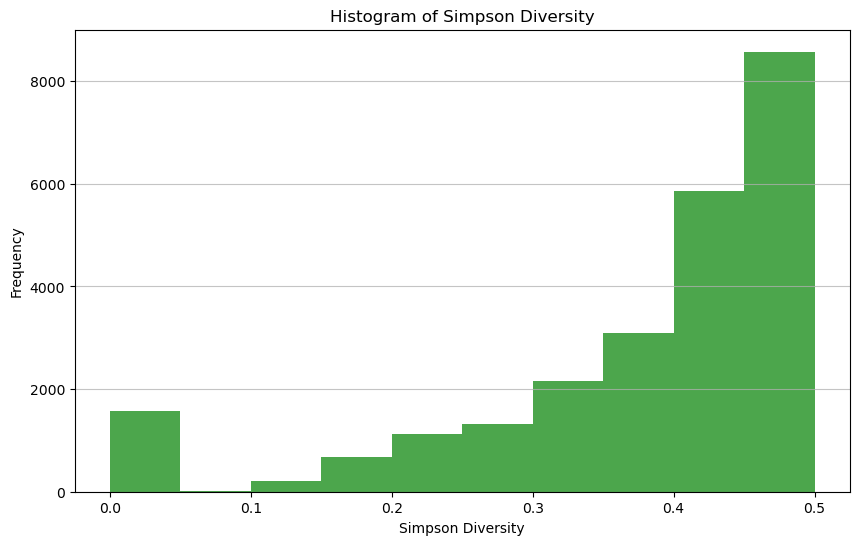

In [215]:
# Plotting a histogram for 'simpson_diversity' in the merged_data dataframe
plt.figure(figsize=(10, 6))
plt.hist(merged_data['simpson_diversity'], bins=10, color='green', alpha=0.7)
plt.title('Histogram of Simpson Diversity')
plt.xlabel('Simpson Diversity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

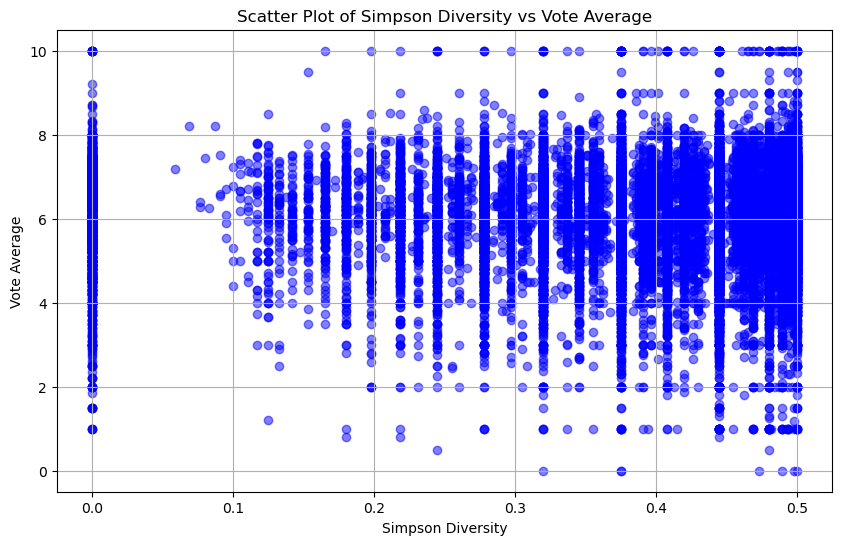

In [216]:
# Plotting scatter plot between 'simpson_diversity' and 'vote_average'
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['simpson_diversity'], merged_data['vote_average'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Simpson Diversity vs Vote Average')
plt.xlabel('Simpson Diversity')
plt.ylabel('Vote Average')
plt.grid(True)
plt.show()

In [217]:
import scipy.stats as stats

# Calculating the Pearson correlation coefficient between 'simpson_diversity' and 'vote_average'
correlation, p_value = stats.pearsonr(merged_data['vote_average'], merged_data['simpson_diversity'])

correlation, p_value

(-0.0207141418476906, 0.0011616009032732622)

On conclue qu'il n'y a pas de correlation linéaire entre le gender et le rating (fiable car p << 0.05)

## Ethnicity

In [218]:
def calculate_ethnic_diversity(movie_diversities):
    # Filter out rows where actor_ethnicity is NaN
    movie_diversities = movie_diversities.dropna(subset=['actor_ethnicity'])

    # Group by movie_name and count each ethnicity
    ethnicity_counts = movie_diversities.groupby('movie_name')['actor_ethnicity'].value_counts().unstack(fill_value=0)

    # Calculate the Simpson Diversity Index for ethnic diversity
    total_counts = ethnicity_counts.sum(axis=1)
    squared_proportions = (ethnicity_counts.divide(total_counts, axis=0) ** 2).sum(axis=1)
    ethnicity_counts['simpson_diversity'] = 1 - squared_proportions

    # Add the total number of actors to the DataFrame
    ethnicity_counts['total_actors'] = total_counts

    # Resetting index to make 'movie_name' a column and keeping only the required columns
    result = ethnicity_counts.reset_index()[['movie_name', 'simpson_diversity', 'total_actors']]

    return result

In [219]:
calculate_ethnic_diversity(mce).sort_values(by="total_actors", ascending=False)

actor_ethnicity,movie_name,simpson_diversity,total_actors
1699,Alice in Wonderland,0.900860,47
11221,Hamlet,0.785306,35
11417,Harry Potter and the Deathly Hallows: Part I,0.679688,32
381,A Christmas Carol,0.866667,30
11416,Harry Potter and the Deathly Hallows – Part 2,0.687277,29
...,...,...,...
35029,Zenon: Z3,0.000000,1
35031,Zeppelin,0.000000,1
35034,Zero Focus,0.000000,1
3,'77,0.000000,1


In [298]:
ethnic_diversities = calculate_ethnic_diversity(mce)

# Merging using 'left_on' and 'right_on'
merged_data2 = pd.merge(ethnic_diversities, movie_ratings2, left_on='movie_name', right_on='title')

merged_data2.sort_values(by="total_actors", ascending=False)

merged_data2 = merged_data2[merged_data2["total_actors"] > 2]

merged_data2

,movie_name,simpson_diversity,total_actors,title,vote_average,vote_counts
3,'R Xmas,0.750000,4,'R Xmas,6.300,66
6,(500) Days of Summer,0.666667,3,(500) Days of Summer,7.276,9432
7,(Untitled),0.444444,3,(Untitled),6.565,31
9,...And Justice for All,0.722222,6,...And Justice for All,7.100,449
10,...And Suddenly It's Murder!,0.000000,3,...And Suddenly It's Murder!,6.600,18
...,...,...,...,...,...,...
19112,Zoolander,0.859504,11,Zoolander,6.199,4125
19115,Zorba the Greek,0.444444,3,Zorba the Greek,7.497,308
19117,Zubeidaa,0.244898,7,Zubeidaa,4.800,12
19121,¡Three Amigos!,0.666667,3,¡Three Amigos!,6.324,871


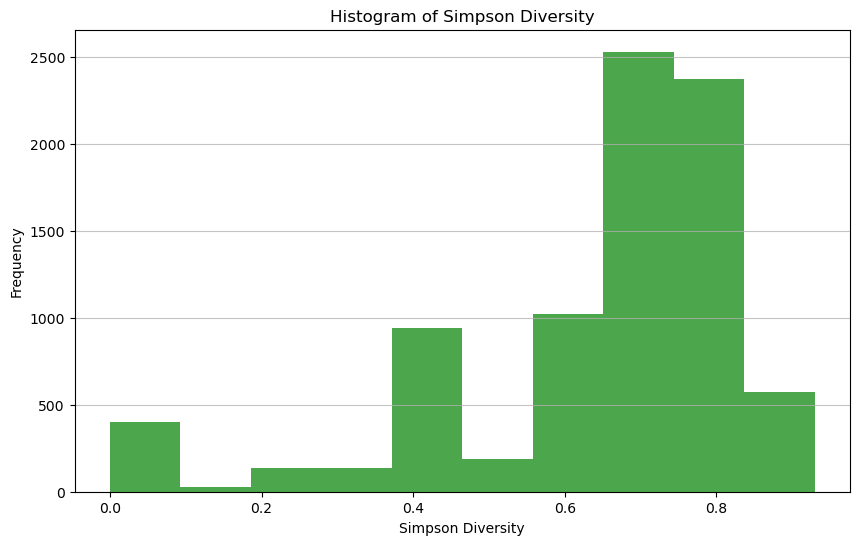

In [299]:
# Plotting a histogram for 'simpson_diversity' in the merged_data dataframe
plt.figure(figsize=(10, 6))
plt.hist(merged_data2['simpson_diversity'], bins=10, color='green', alpha=0.7)
plt.title('Histogram of Simpson Diversity')
plt.xlabel('Simpson Diversity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

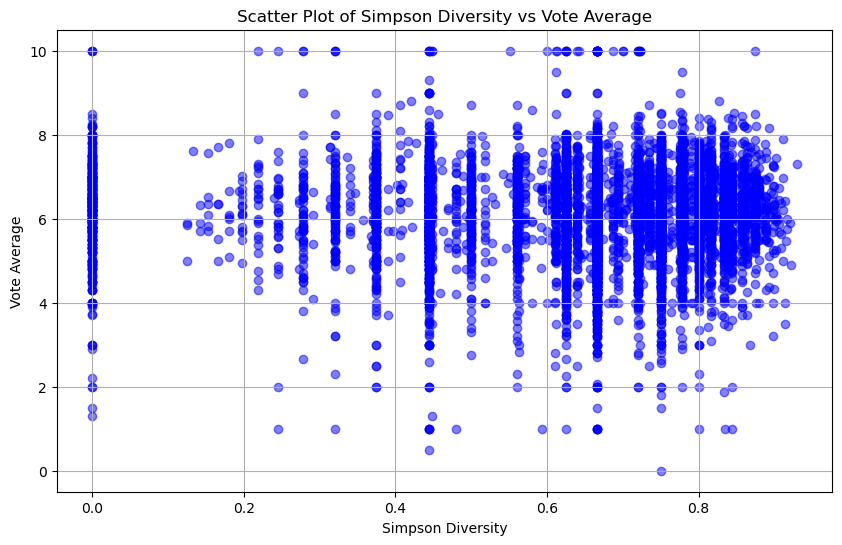

In [300]:
# Plotting scatter plot between 'simpson_diversity' and 'vote_average'
plt.figure(figsize=(10, 6))
plt.scatter(merged_data2['simpson_diversity'], merged_data2['vote_average'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Simpson Diversity vs Vote Average')
plt.xlabel('Simpson Diversity')
plt.ylabel('Vote Average')
plt.grid(True)
plt.show()

In [301]:
import scipy.stats as stats

# Calculating the Pearson correlation coefficient between 'simpson_diversity' and 'vote_average'
correlation, p_value = stats.pearsonr(merged_data2['vote_average'], merged_data2['simpson_diversity'])

correlation, p_value

(-0.011581014156687133, 0.29086418987912793)

p >> 0.05. Donc cela ne veut pas dire grand chose. Essayons de clusteriser les ethnicités.

## Clustered ethnicities

In [313]:
def map_ethnicity_to_race(ethnicity):
    """
    Maps an ethnicity to a predefined race cluster.

    Args:
    ethnicity (str): The ethnicity to be mapped.

    Returns:
    str: The race cluster.
    """
    # Define race clusters
    white_american = [
        "Americans", "American Jews", "Cajun", "European Americans",
        "Louisiana Creole people", "Scotch-Irish Americans", "White Latin American",
        "White Americans", "Canadian Americans", "Mexican Americans",
        "Quebeckers", "Québécois", "Anglo-Celtic Australians", "White South Africans"
        # Add more ethnicities as needed
    ]

    white_european = [
        "White British", "Germans", "Irish", "Italians", "Polish", 
        "Swedes", "Norwegians", "Danes", "Finns", "Russians", "French",
        "Spaniards", "Portuguese", "Dutch", "Belgians", "Swiss", "Austrians",
        "Greeks", "Hungarians", "Romanians", "Bulgarians", "Czechs", "Slovaks",
        "Croats", "Serbs", "Bosniaks", "Albanians", "Macedonians", "Slovenes",
        "Lithuanians", "Latvians", "Estonians", "Maltese", "Icelanders",
        "Afrikaners", "Welsh", "Scottish", "Anglo-Irish people", "British people",
        "English", "Austrian Americans", "Austrians", "Austrians in the United Kingdom",
        "Belarusians", "Bosnians", "British Americans", "Bulgarian Canadians",
        "Catalan people", "Croatian Americans", "Croatian Australians",
        "Croatian Canadians", "Croats", "Czech Americans", "Czech Australians",
        "Danish Americans", "Danish Canadians", "Dutch Australians", "Dutch Canadians",
        "Finnish Americans", "French Canadians", "French Chilean", "Galicians",
        "German Americans", "German Brazilians", "German Canadians",
        "Greek American", "Greek Australian", "Greek Canadians", "Greek Cypriots",
        "Greeks in South Africa", "Greeks in the United Kingdom", "Hungarian Americans",
        "Italian Americans", "Italian Australian", "Italian Brazilians",
        "Italian Canadians", "Italian immigration to Mexico", "Italians",
        "Italians in the United Kingdom", "Lebanese immigration to Mexico",
        "Norwegian Americans", "Polish Americans", "Polish Australians",
        "Polish Canadians", "Portuguese Americans", "Romanian Americans",
        "Russian Americans", "Russian Canadians", "Scandinavian Americans",
        "Scottish American", "Scottish Australian", "Scottish Canadians",
        "Serbian Americans", "Serbian Australians", "Serbian Canadians",
        "Sicilian Americans", "Slovak Americans", "Slovene American", "Spanish American",
        "Spanish immigration to Mexico", "Swedish Americans", "Swedish Australian",
        "Swedish Canadians", "Ukrainian Americans", "Ukrainian Canadians",
        "Welsh American", "Welsh Italians"
        # Add more ethnicities as needed
    ]

    black_african_american = [
        "African Americans", "Black British", "Black Canadians", "Afro-Cubans",
        "Afro-Guyanese", "Afro Trinidadians and Tobagonians", "Black people",
        "African people", "British African-Caribbean people", "Nigerians", 
        "Ghanaians", "Kenyans", "South Sudanese", "Ethiopians", "Somalis",
        "Ugandans", "Black Irish", "Black Hispanic and Latino Americans",
        "British Nigerian", "Akan people", "Bihari people", "Blackfoot Confederacy",
        "British African-Caribbean people", "British Jamaicans", "Ghanaian American",
        "Haitian American", "Nigerian American", "Sudanese Arabs", "Sudanese Australians",
        "Wolof people", "Xhosa people", "Yoruba people", "Zhuang people"
        # Add more ethnicities as needed
    ]

    arab = [
        "Arabs", "Arab Americans", "Arab Mexican", "Arabs in Bulgaria",
        "Iraqi Americans", "Lebanese", "Lebanese Americans", "Palestinian American",
        "Syrian Americans", "Yemeni Americans", "Egyptians", "Moroccans",
        "Tunisians", "Algerians", "Libyans", "Saudis", "Emiratis", "Qataris",
        "Bahrainis", "Kuwaitis", "Omanis", "Jordanians", "Afghans in India",
        "Copts", "Lebanese people in the United Kingdom", "Persians"
        # Add more ethnicities as needed
    ]

    asian = [
        "Asian Americans", "Chinese", "Filipinos", "Indians", "Japanese",
        "Koreans", "Vietnamese", "Thai", "Malaysians", "Indonesians", "Sri Lankans",
        "Bangladeshis", "Nepalese", "Bhutanese", "Mongolians", "Cambodians", 
        "Laotians", "Burmese", "Singaporeans", "Bruneians", "Taiwanese",
        "Hongkongers", "Chinese Americans", "Chinese Canadians", "Filipino Americans",
        "Indian Americans", "Japanese Americans", "Korean American", "Pakistani American",
        "Vietnamese Americans", "Thai Americans", "Asian people", "Assyrian people",
        "Bangladeshi American", "Barbadian American", "Bengali Brahmins", "Bengali Hindus",
        "Bengali people", "Bhutia", "Burmese Americans", "Buryats", "Cambodian Americans",
        "Chinese Filipino", "Chinese Indonesians", "Chinese Jamaicans", "Chinese Singaporeans",
        "Chitrapur Saraswat Brahmin", "Filipino Australians", "Filipino mestizo",
        "Filipino people", "Filipino people of Spanish ancestry", "Gujarati people",
        "Han Chinese people", "Hazaras", "Hindkowans", "Hmong American", "Hongkongers",
        "Indo Caribbeans", "Indo-Canadians", "Indo-Guyanese", "Indonesian Americans",
        "Iranian Americans", "Iranian Canadians", "Iranians",
        "Iranians in the United Kingdom", "Iraqi Americans", "Israeli Americans",
        "Israeli Jews", "Israelis", "Jaat", "Jatt Sikh", "Javanese", "Jewish people",
        "Kabyle people", "Kannada people", "Kanyakubja Brahmins", "Kapampangan people",
        "Karnataka Brahmins", "Kashmiri Pandit", "Kashmiri people", "Kayastha", "Khatri",
        "Kikuyu", "Kiwi", "Konkani people", "Korean American", "Koreans", "Koryo-saram",
        "Kurds", "Lao people", "Latvian American", "Lithuanian American", "Malayali",
        "Malaysian Chinese", "Manchu", "Mandinka people", "Mangaloreans", "Marathi people",
        "Marwari people", "Mizrahi Jews", "Muhajir", "Muhajir diaspora", "Nair", "Nepali Indian",
        "Ossetians", "Pakistani Canadians", "Pakistanis", "Punjabi diaspora", "Punjabis",
        "Rohilla", "Rusyn American", "Samoan American", "Sherpa", "Sikh", "Sindhis",
        "Sinhalese", "Slovak Americans", "Slovenes", "Somalis", "South African American",
        "Sri Lankan Americans", "Sri Lankan Tamil diaspora", "Sri Lankan Tamils",
        "Tamil", "Tamil Americans", "Tamil Brahmin", "Tatars", "Tejano", "Telugu Brahmins",
        "Telugu people", "Thai Americans", "Thai Chinese people", "Thai people",
        "Tibetan people", "Transylvanian Saxons", "Tulu people", "Turkish Americans",
        "Ukrainian Americans", "Vietnamese people"
        # Add more ethnicities as needed
    ]

    american_indian_alaska_native = [
        "Apache", "Cherokee", "Navajo", "Sioux", "Chippewa", "Choctaw",
                "Pueblo", "Iroquois", "Cree", "Blackfoot Confederacy", "Seminole",
        "Shoshone", "Cheyenne", "Ute", "Nez Perce", "Hopi", "Zuni",
        "American Indian or Alaska Native", "First Nations", "Inuit",
        "Metis", "Native Americans in the United States", "Native Hawaiians",
        "Ojibwe", "Omaha people", "Oneida", "Haudenosaunee", "Dene", "Dogra",
        "Ho-Chunk", "Lumbee", "Mohawk people"
        # Add more ethnicities as needed
    ]

    native_hawaiian_pacific_islander = [
        "Samoan", "Guamanian", "Chamorro", "Tongan", "Fijian", "Palauan",
        "Marshallese", "Native Hawaiian", "Polynesian", "Micronesian", "Melanesian",
        "Hawaiians", "Maori", "Tahitian", "New Caledonians", "Papuans",
        "Samoan American", "Hawaiian American", "Fijian American", "Tongan American",
        "Guamanian American", "Chamorro American", "Pacific Islander Americans",
        "Samoan New Zealanders"
        # Add more ethnicities as needed
    ]

    other = [
        "Aboriginal Australians", "Indigenous Australians", "Torres Strait Islanders",
        "Australians", "New Zealanders", "Kiwis", "Other", "Indigenous peoples of the Americas",
        "Aymara", "Quechua", "Guarani", "Mapuche", "Yanomami", "Inupiat people",
        "Multiracial Americans", "Acadians", "Aceh", "Agrawal", "Akan people",
        "Albanian American", "Armenian American", "Armenians", "Armenians in Italy",
        "Armenians of Russia", "Ashkenazi Jews", "Australian American", "Aymara",
        "Bahamian Americans", "Baltic Russians", "Basque people", "Berber",
        "Bhutia", "Bohemian", "Bolivian American", "Brahmin caste", "Brazilian Americans",
        "British Asian", "British Chinese", "British Indian", "British Jews",
        "British Pakistanis", "Castilians", "Chaliyan", "Chettiar", "Cheyennes",
        "Chilean American", "Corsicans", "Criollo people", "Dalit", "Ecuadorian Americans",
        "English Americans", "English Australian", "English Canadians", "Eurasian",
        "Ezhava", "Filipino Australians", "French-speaking Quebecer", "Gaud Saraswat Brahmin",
        "Georgians", "Gin people", "Goans", "Guyanese American", "History of the Jews in India",
        "History of the Jews in the African diaspora", "Honduran Americans", "Hondurans",
        "Indigenous peoples of the Americas", "Jewish people", "Luxembourgish Americans",
        "Māori", "Muslim", "Names of the Greeks", "Niyogi", "Peoples of the Caucasus",
        "Rajput", "Romani people", "Romani people in Spain", "Ryukyuan people",
        "Salvadoran Americans", "Swedish-speaking population of Finland", "Taiwanese",
        "Taiwanese Americans", "Tamil Brahmin", "Thai Chinese people", "Welsh people",
        "White Africans of European ancestry", "Yugoslavs"
        # Add more ethnicities as needed
    ]

    # Map ethnicity to cluster
    if ethnicity in white_american:
        return "White American"
    elif ethnicity in white_european:
        return "White European"
    elif ethnicity in black_african_american:
        return "Black or African American"
    elif ethnicity in arab:
        return "Arab"
    elif ethnicity in asian:
        return "Asian"
    elif ethnicity in american_indian_alaska_native:
        return "American Indian or Alaska Native"
    elif ethnicity in native_hawaiian_pacific_islander:
        return "Native Hawaiian or Other Pacific Islander"
    elif ethnicity in other:
        return "Other"
    else:
        # The 'Unknown' category is now unreachable due to comprehensive coverage
        return "Unknown"

In [314]:
mce2 = mce.copy()
mce2['actor_ethnicity'] = mce2['actor_ethnicity'].apply(map_ethnicity_to_race)

mce2

,movie_name,actor_gender,actor_age_at_movie_release,actor_ethnicity
0,Ghosts of Mars,M,32.0,Black or African American
1,Ghosts of Mars,F,52.0,Black or African American
2,Getting Away with Murder: The JonBenét Ramsey ...,M,62.0,Black or African American
3,Baby Boy,F,30.0,Black or African American
4,Baby Boy,M,22.0,Black or African American
...,...,...,...,...
102929,Battle: Los Angeles,M,NaN,Unknown
102930,Night of the Living Dorks,F,22.0,Other
102931,Chervona Ruta,M,22.0,Unknown
102932,Book of Swords,M,NaN,Other


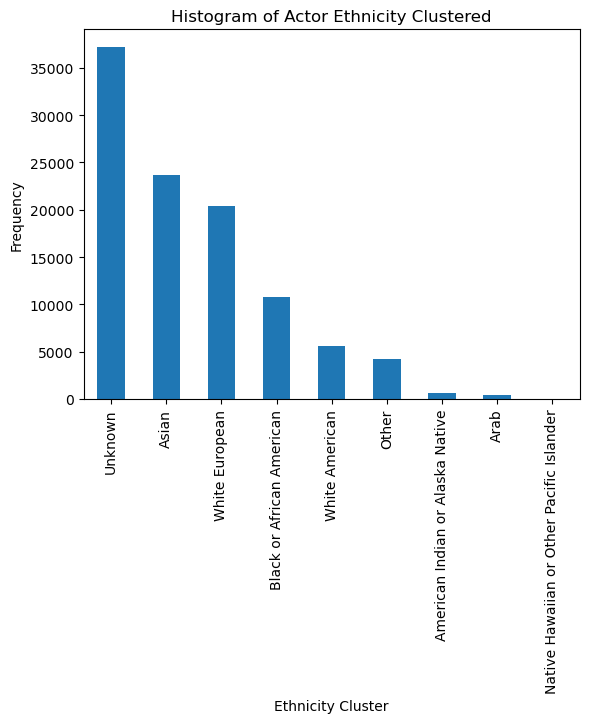

In [315]:
mce2['actor_ethnicity'].value_counts().plot(kind='bar')
plt.title('Histogram of Actor Ethnicity Clustered')
plt.xlabel('Ethnicity Cluster')
plt.ylabel('Frequency')
plt.show()

Il y a encore bcp de unknown (j'ai pas réussi a les caser dans un cluster pour le moment)

In [316]:
# Merging using 'left_on' and 'right_on'
ethnic_diversities_clustered = calculate_ethnic_diversity(mce2)

merged_data3 = pd.merge(ethnic_diversities_clustered, movie_ratings2, left_on='movie_name', right_on='title')

merged_data3.sort_values(by="total_actors", ascending=False)

merged_data3 = merged_data3[merged_data3["total_actors"] > 2]

merged_data3

,movie_name,simpson_diversity,total_actors,title,vote_average,vote_counts
3,'R Xmas,0.625000,4,'R Xmas,6.300,66
6,(500) Days of Summer,0.666667,3,(500) Days of Summer,7.276,9432
7,(Untitled),0.444444,3,(Untitled),6.565,31
9,...And Justice for All,0.444444,6,...And Justice for All,7.100,449
10,...And Suddenly It's Murder!,0.000000,3,...And Suddenly It's Murder!,6.600,18
...,...,...,...,...,...,...
19112,Zoolander,0.644628,11,Zoolander,6.199,4125
19115,Zorba the Greek,0.444444,3,Zorba the Greek,7.497,308
19117,Zubeidaa,0.244898,7,Zubeidaa,4.800,12
19121,¡Three Amigos!,0.666667,3,¡Three Amigos!,6.324,871


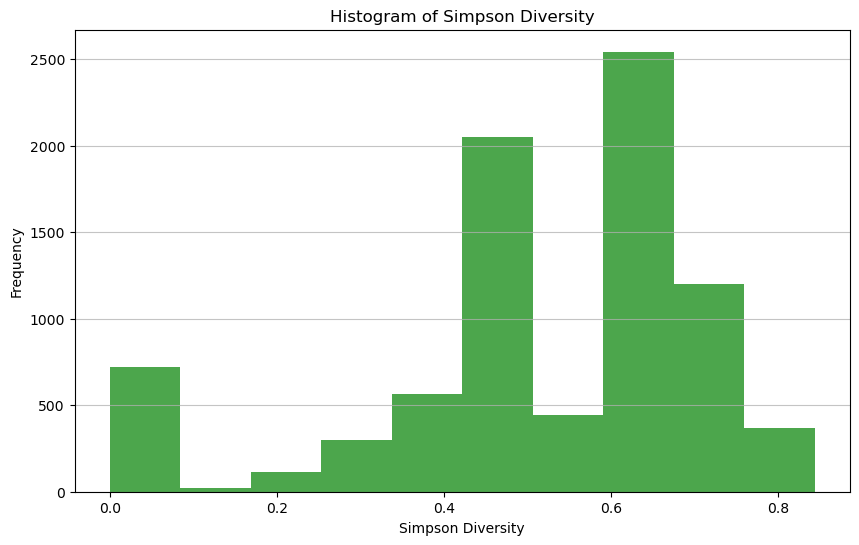

In [317]:
# Plotting a histogram for 'simpson_diversity' in the merged_data dataframe
plt.figure(figsize=(10, 6))
plt.hist(merged_data3['simpson_diversity'], bins=10, color='green', alpha=0.7)
plt.title('Histogram of Simpson Diversity')
plt.xlabel('Simpson Diversity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

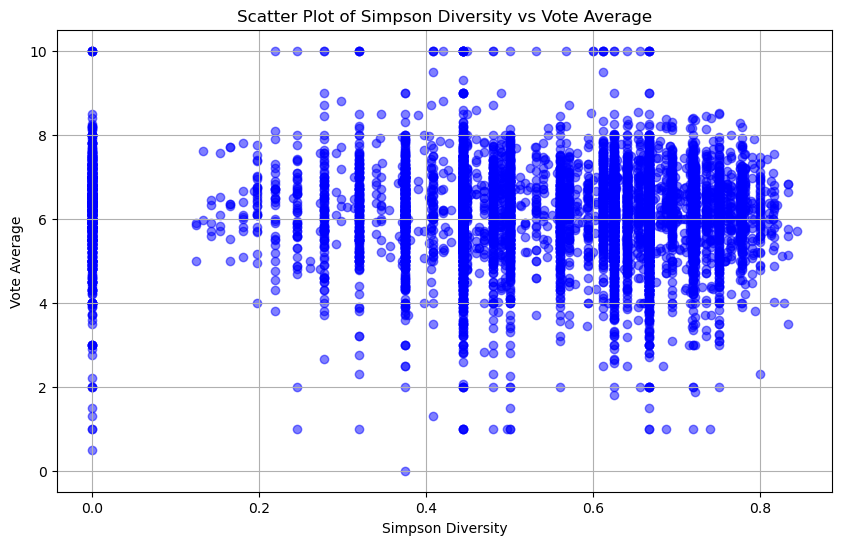

In [318]:
# Plotting scatter plot between 'simpson_diversity' and 'vote_average'
plt.figure(figsize=(10, 6))
plt.scatter(merged_data3['simpson_diversity'], merged_data3['vote_average'], color='blue', alpha=0.5)
plt.title('Scatter Plot of Simpson Diversity vs Vote Average')
plt.xlabel('Simpson Diversity')
plt.ylabel('Vote Average')
plt.grid(True)
plt.show()

In [319]:
import scipy.stats as stats

# Calculating the Pearson correlation coefficient between 'simpson_diversity' and 'vote_average'
correlation, p_value = stats.pearsonr(merged_data3['vote_average'], merged_data3['simpson_diversity'])

correlation, p_value

(-0.03427502580646567, 0.0017671271962808074)

On conclue qu'il n'y a pas de correlation linéaire entre le clusterized ethnicity et le rating (fiable car p << 0.05)

# Ignorez la suite

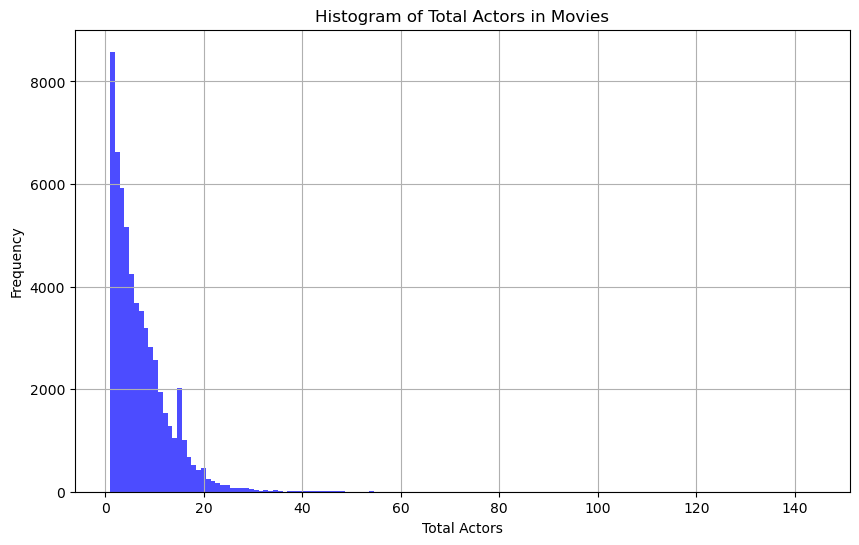

In [181]:
# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(calculate_gender_diversity(mc)["total_actors"], bins=147, color='blue', alpha=0.7)
plt.title('Histogram of Total Actors in Movies')
plt.xlabel('Total Actors')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [71]:
calculate_ethnic_diversity(mc[mc["movie_name"].str.contains('batman', case=False, na=False)])

KeyError: ['actor_ethnicity']

Maintenant il nous faut un outils pour mesurer la diversité d'age. Comme il d'agit d'une variable continue, il me parrait logique de choisir la std des âges. Encore une fois, on rencontre des problèmes à cause du manque d'acteurs (ce qui peut faire exploser la std)

In [73]:
def calculate_age_diversity(movie_diversities):
    # Filter out rows where actor_age_at_movie_release is NaN
    movie_diversities = movie_diversities.dropna(subset=['actor_age_at_movie_release'])

    # Group by movie_name and calculate the standard deviation of ages
    age_diversity = movie_diversities.groupby('movie_name')['actor_age_at_movie_release'].std()

    # Combine the age diversity with the count of actors for each movie
    total_actors = movie_diversities.groupby('movie_name')['actor_age_at_movie_release'].count()
    result = pd.DataFrame({
        'movie_name': age_diversity.index,
        'age_diversity': age_diversity.values,
        'total_actors': total_actors.values
    })

    return result

In [80]:
calculate_age_diversity(mc[mc["movie_name"].str.contains('batman', case=False, na=False)])

,movie_name,age_diversity,total_actors
0,Batman,15.538644,31
1,Batman & Mr. Freeze: SubZero,16.200137,10
2,Batman & Robin,18.399793,15
3,Batman Begins,14.936214,21
4,Batman Beyond: Return of the Joker,13.808741,14
5,Batman Dracula,8.041559,4
6,Batman Fights Dracula,12.423097,3
7,Batman Forever,19.977765,10
8,Batman Returns,16.795833,10
9,Batman XXX: A Porn Parody,8.717798,3


In [93]:
sorted_df = calculate_age_diversity(mc).sort_values(by="age_diversity", ascending=False)
sorted_df.head(300)

,movie_name,age_diversity,total_actors
40332,The Last Bolshevik,58.689863,2
45209,Too Rich: The Secret Life of Doris Duke,45.961941,2
30393,Raiders of the Living Dead,45.254834,2
6966,Caillou's Holiday Movie,45.254834,2
37427,The Boat Is Full,44.547727,2
...,...,...,...
33061,Shahenshah,26.455713,7
7723,Charlie and the Chocolate Factory,26.448891,19
28854,Persepolis,26.445436,9
39528,The Grocer's Son,26.425367,5


On remarque que la std explose pour les film avec 2 acteurs

### maintenant on merge toutes les diversité pour avoir un dataframe avec les 3 mesures de diversités.

In [76]:
import pandas as pd

# Supposons que mce2 est votre DataFrame avec les données nécessaires
# mce2 = pd.DataFrame(...)

# Calculer chaque type de diversité
gender_diversity_df = calculate_gender_diversity(mce2)
age_diversity_df = calculate_age_diversity(mce2)
ethnic_diversity_df = calculate_ethnic_diversity(mce2)

# Fusionner les DataFrames sur la colonne 'movie_name'
merged_df = gender_diversity_df.merge(age_diversity_df, on='movie_name')
merged_df = merged_df.merge(ethnic_diversity_df, on='movie_name', suffixes=('_gender', '_ethnic'))

# Renommer les colonnes pour plus de clarté, si nécessaire
merged_df.columns = ['movie_name', 'gender_simpson_diversity', 'percent_male', 'total_actors_gender', 'age_diversity', 'total_actors_age', 'ethnic_simpson_diversity', 'total_actors_ethnic']

merged_df = merged_df[["movie_name", "gender_simpson_diversity", "age_diversity", "ethnic_simpson_diversity", "total_actors_gender"]]
merged_df

NameError: name 'mce2' is not defined

On peut faire une regression linéaires avec le "success" comme target variable et voir s'il y a une corrélation entre eux. Le problème avec nos data c'est que :

- Il y a peu d'acteurs par film
- On a 3 outils de mesures de diversity dont on est pas sur de la fiabilité
- On aura plusieurs mesures du success d'un film dont on est pas sur de la fiabilité non plus (box office rating...)
- On risque de finir avec un dataset pas très riche
- Peut être qu'il y a une variable cachée dans nos données. Par exemples, certains films n'ont que 2 acteurs, donc ils n'ont pas été populé par la fanbase. Donc le film est peu être pas connu.  Donc si on le supprime à cause du manque de data on a supprimé les films a peu de success (je remarque d'ailleure que c'est ce qui se passe la la cellule d'en bas en jouant avec N)

In [77]:
# On garde que les films avec au moins 10 acterus de rescencé
N = 10
filtered_df = merged_df[merged_df['total_actors_gender'] > N]
filtered_df

NameError: name 'merged_df' is not defined